# 1 Data Quality Checks

In [33]:
import pandas as pd
import numpy as np

# Load raw data
df = pd.read_csv("Nightreign Data - NightReign Data.csv")

# Display first few rows
print("Preview of raw data:")
display(df.head())

Preview of raw data:


,run_id,run_index_in_day,character,difficulty,nightlord,enhanced,map,run_outcome,evergaol_cleared,middle_castle_visited,great_enemies_cleared,enemies_cleared,team_type,allies_rescued,runes_obtained,level,notes
0,1,1,recluse,depth1,Gladius,False,base,final_day,3,False,9,79,duo,8,362296,12,NaN
1,2,2,recluse,depth1,Gladius,False,base,victory,4,True,13,99,duo,8,482476,14,NaN
2,3,3,recluse,depth1,Caligo,False,crater,second_day,2,False,8,110,duo,4,361842,11,NaN
3,4,4,recluse,depth1,Caligo,False,crater,second_day,2,False,8,60,trio,9,253560,10,NaN
4,5,5,recluse,depth1,Caligo,False,crater,second_day,3,True,8,55,trio,17,282060,9,NaN


## 1.1 Data Quality Checks

This section evaluates the initial quality of the dataset.  
We inspect missing values, duplicated rows, inconsistent entries, and unusual distributions. These checks help identify potential issues that may bias statistical tests or distort downstream analysis. Ensuring data integrity at this stage is essential before performing any hypothesis testing or feature engineering.


In [34]:
print("DATA QUALITY CHECKS")

# Check for missing values
print("\n Missing Values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("✓ No missing values found!")
else:
    print(missing[missing > 0])

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\n Duplicate Rows: {duplicates}")
if duplicates > 0:
    print(f"  Removing {duplicates} duplicate rows...")
    df = df.drop_duplicates()


DATA QUALITY CHECKS

 Missing Values:
notes    116
dtype: int64

 Duplicate Rows: 0


## 1.2 Ordinal Conversions

Several variables in the dataset represent ordered categories rather than numerical values (e.g., day progression, outcome tiers, difficulty levels).  
In this section, these categorical variables are mapped to ordered numerical scales.  
Converting them into ordinal values enables quantitative analysis, group comparisons, and hypothesis testing using statistical methods that expect numeric input.


In [35]:
# Convert run_outcome to ordinal (0-3)
outcome_mapping = {
    'first_day': 0,
    'second_day': 1,
    'final_day': 2,
    'victory': 3
}
df['run_outcome_ordinal'] = df['run_outcome'].map(outcome_mapping)

# Convert difficulty to ordinal (1-5)
difficulty_mapping = {
    'depth1': 1,
    'depth2': 2,
    'depth3': 3,
    'depth4': 4,
    'depth5': 5
}
df['difficulty_ordinal'] = df['difficulty'].map(difficulty_mapping)

## 1.3 Binary Outcome Variable

To enable clear success–failure analysis, we construct a binary outcome variable that represents whether a run resulted in a final victory.  
This simplifies the analysis of performance factors by allowing us to apply logistic regression, compare proportions, and evaluate how specific features influence the probability of success.


In [36]:
# Create binary victory column (0/1)
df['victory_binary'] = (df['run_outcome'] == 'victory').astype(int)

victory_rate = df['victory_binary'].mean() * 100

## 1.4 Feature Engineering

This section introduces new derived variables to better capture patterns relevant to performance.  
Examples include resource metrics, timing adjustments, interaction effects, and recategorized features that align more closely with gameplay mechanics.  
Feature engineering enhances the predictive power of the dataset and allows deeper insight into strategic decision-making.

In [37]:
# --- Resource Allocation Metrics ---
# Total optional content cleared
df['total_optional_content'] = df['evergaol_cleared'] + df['great_enemies_cleared']

# Loot priority score (proxy for loot quality, replacing subjective loot_quality_score)
# Weight castle higher (3x) since it provides premium loot
df['loot_priority_score'] = (
    df['great_enemies_cleared'] + 
    (df['middle_castle_visited'].astype(int) * 3)
)

# Buff-to-loot ratio (strategy indicator)
df['buff_to_loot_ratio'] = df['evergaol_cleared'] / (df['great_enemies_cleared'] + 1)

# Risk-taking score
df['risk_taking_score'] = df['evergaol_cleared'] + df['middle_castle_visited'].astype(int)

# --- Efficiency Metrics ---
# Combat efficiency (quality of kills)
df['combat_efficiency'] = df['great_enemies_cleared'] / (df['enemies_cleared'] + 1)

# Resource efficiency (runes per level)
df['runes_per_level'] = df['runes_obtained'] / (df['level'] + 1)

# Leveling efficiency (how quickly did you level up)
df['enemies_per_level'] = df['enemies_cleared'] / (df['level'] + 1)


# --- Session-Level Features ---
# Calculate session ID (group consecutive runs with run_index_in_day starting from 1)
df['session_id'] = (df['run_index_in_day'] == 1).cumsum()

# Within-session cumulative stats
df = df.sort_values(['session_id', 'run_index_in_day'])
df['cumulative_wins_in_session'] = df.groupby('session_id')['victory_binary'].cumsum()
df['win_rate_so_far_in_session'] = df['cumulative_wins_in_session'] / df['run_index_in_day']

# Previous run outcome (lagged feature)
df['prev_run_outcome_ordinal'] = df.groupby('session_id')['run_outcome_ordinal'].shift(1)

# Is this after a victory?
df['after_victory'] = (df.groupby('session_id')['victory_binary'].shift(1) == 1).astype(float)

# --- Strategy Categorization ---
def categorize_strategy(row):
    """
    Categorize each run into a strategy type based on resource allocation
    """
    evergaol_threshold = df['evergaol_cleared'].quantile(0.75)  # Top 25%
    great_enemy_threshold = df['great_enemies_cleared'].median()
    
    if row['evergaol_cleared'] >= evergaol_threshold:
        return 'buff_focused'
    elif row['great_enemies_cleared'] >= great_enemy_threshold:
        return 'loot_focused'
    elif row['middle_castle_visited']:
        return 'high_risk_castle'
    else:
        return 'speedrun'

df['strategy_type'] = df.apply(categorize_strategy, axis=1)

## 1.5 Data Type Conversions

To prepare the dataset for exploration and hypothesis testing, all variables are converted to appropriate data types (numeric, categorical, boolean).  

In [38]:
# Convert boolean columns to proper type
boolean_cols = ['middle_castle_visited', 'enhanced']
for col in boolean_cols:
    if col in df.columns:
        df[col] = df[col].astype(bool)

# Ensure categorical columns are proper type
categorical_cols = ['character', 'difficulty', 'nightlord', 'map', 
                    'run_outcome', 'team_type', 'strategy_type']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

## 1.6 Final Dataset Summary


In [39]:
print("PROCESSED DATASET SUMMARY")

print(f"\n Final dataset shape: {df.shape}")
print(f"   Rows: {df.shape[0]}")
print(f"   Columns: {df.shape[1]}")

print("\n New columns created:")
new_columns = [
    'run_outcome_ordinal', 'difficulty_ordinal', 'victory_binary',
    'total_optional_content', 'loot_priority_score', 'buff_to_loot_ratio',
    'risk_taking_score', 'combat_efficiency', 'runes_per_level',
    'enemies_per_level', 'session_id', 'cumulative_wins_in_session',
    'win_rate_so_far_in_session', 'prev_run_outcome_ordinal',
    'after_victory', 'strategy_type'
]
for col in new_columns:
    if col in df.columns:
        print(f"   - {col}")


PROCESSED DATASET SUMMARY

 Final dataset shape: (121, 33)
   Rows: 121
   Columns: 33

 New columns created:
   - run_outcome_ordinal
   - difficulty_ordinal
   - victory_binary
   - total_optional_content
   - loot_priority_score
   - buff_to_loot_ratio
   - risk_taking_score
   - combat_efficiency
   - runes_per_level
   - enemies_per_level
   - session_id
   - cumulative_wins_in_session
   - win_rate_so_far_in_session
   - prev_run_outcome_ordinal
   - after_victory
   - strategy_type


## 1.7 Save Processed Data


In [40]:
import os
os.makedirs('../data/processed', exist_ok=True)

# Save processed dataset
output_path = '../data/processed/nightreign_processed.csv'
df.to_csv(output_path, index=False)

analysis_cols = [
    # Identifiers
    'run_id', 'session_id', 'run_index_in_day',
    # Outcomes (ordinal + binary)
    'run_outcome', 'run_outcome_ordinal', 'victory_binary',
    # Game context
    'character', 'difficulty', 'difficulty_ordinal', 'nightlord', 
    'enhanced', 'map', 'team_type',
    # Resource allocation
    'evergaol_cleared', 'middle_castle_visited', 'great_enemies_cleared',
    # Performance metrics
    'enemies_cleared', 'allies_rescued', 'runes_obtained', 'level',
    # Engineered features
    'total_optional_content', 'loot_priority_score', 'buff_to_loot_ratio',
    'risk_taking_score', 'combat_efficiency', 'runes_per_level',
    'strategy_type', 'after_victory'
]

df_analysis = df[[col for col in analysis_cols if col in df.columns]]
analysis_path = '../data/processed/nightreign_analysis.csv'
df_analysis.to_csv(analysis_path, index=False)

In [41]:
# Check new features
print("\nNew feature samples:")
print(df[['loot_priority_score', 'buff_to_loot_ratio', 'strategy_type']].head())


New feature samples:
   loot_priority_score  buff_to_loot_ratio     strategy_type
0                    9            0.300000          speedrun
1                   16            0.285714      loot_focused
2                    8            0.222222          speedrun
3                    8            0.222222          speedrun
4                   11            0.333333  high_risk_castle



# SECTION 2: EXPLORATORY DATA ANALYSIS


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Create results directory
import os
os.makedirs('../results/figures', exist_ok=True)


# 2.1 DISTRIBUTION ANALYSIS
This section provides a comprehensive overview of how outcomes, characters, difficulty levels, and performance metrics are distributed across all recorded runs.
Understanding these distributions is essential before applying statistical tests or predictive modeling, as it reveals data imbalances, common play patterns, and potential factors influencing success.
By visualizing both categorical and continuous variables, we establish a clear baseline description of player performance and game progression within the dataset.

3.1 DISTRIBUTION ANALYSIS

 Plot 1: Run Outcome Distribution


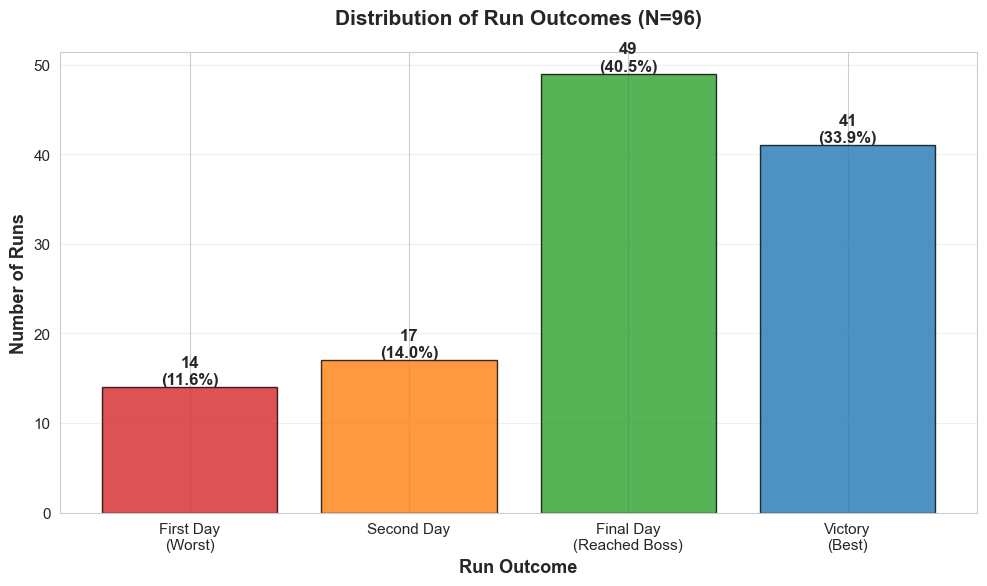


💡 Key Insights:
   • Victory rate: 33.9%
   • Reached Nightlord (final_day + victory): 74.4%
   • Most common outcome: final_day (49 runs)

 Plot 2: Character Usage and Performance


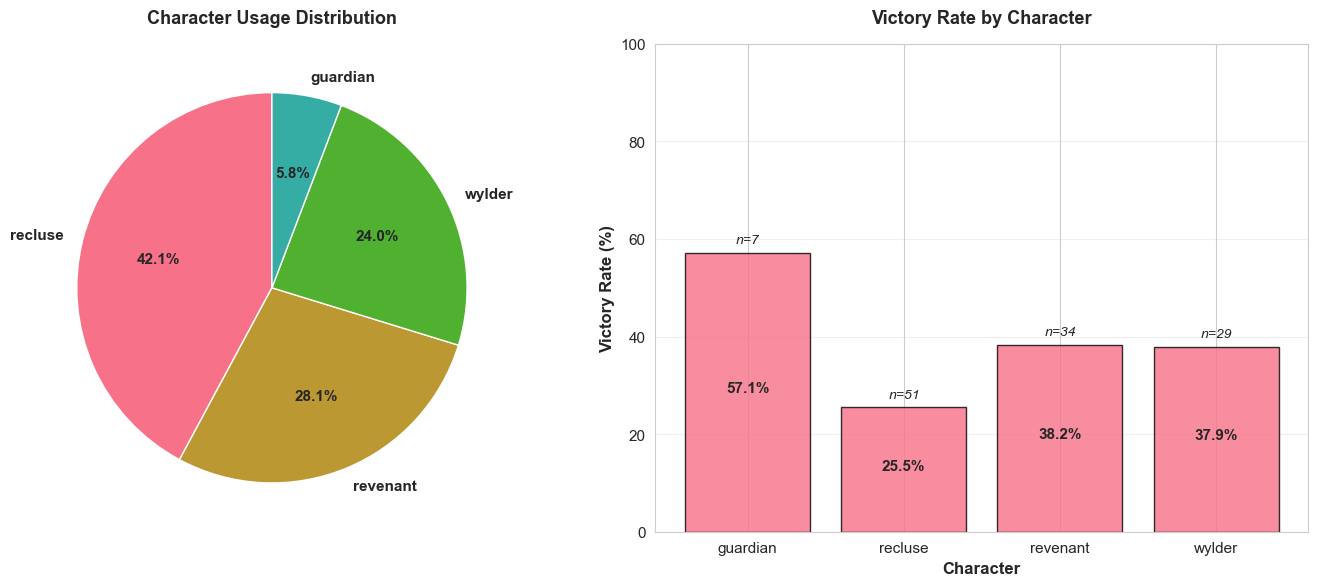


 Key Insights:
   • Most played character: recluse (51 runs)
   • Highest win rate: guardian (57.1%)
   • Lowest win rate: recluse (25.5%)

 Plot 3: Difficulty Distribution and Performance


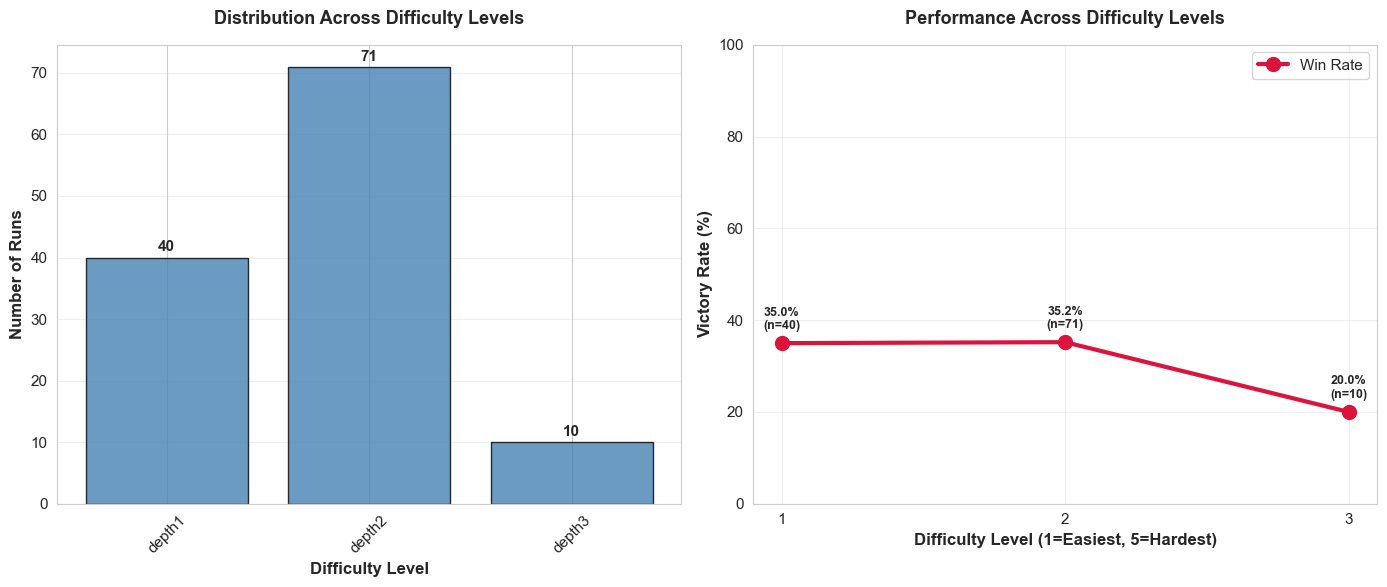


 Key Insights:
   • Most common difficulty: Depth 2 (71 runs)
   • Win rate trend: 35.0% → 20.0%

 Plot 4: Distribution of Performance Metrics


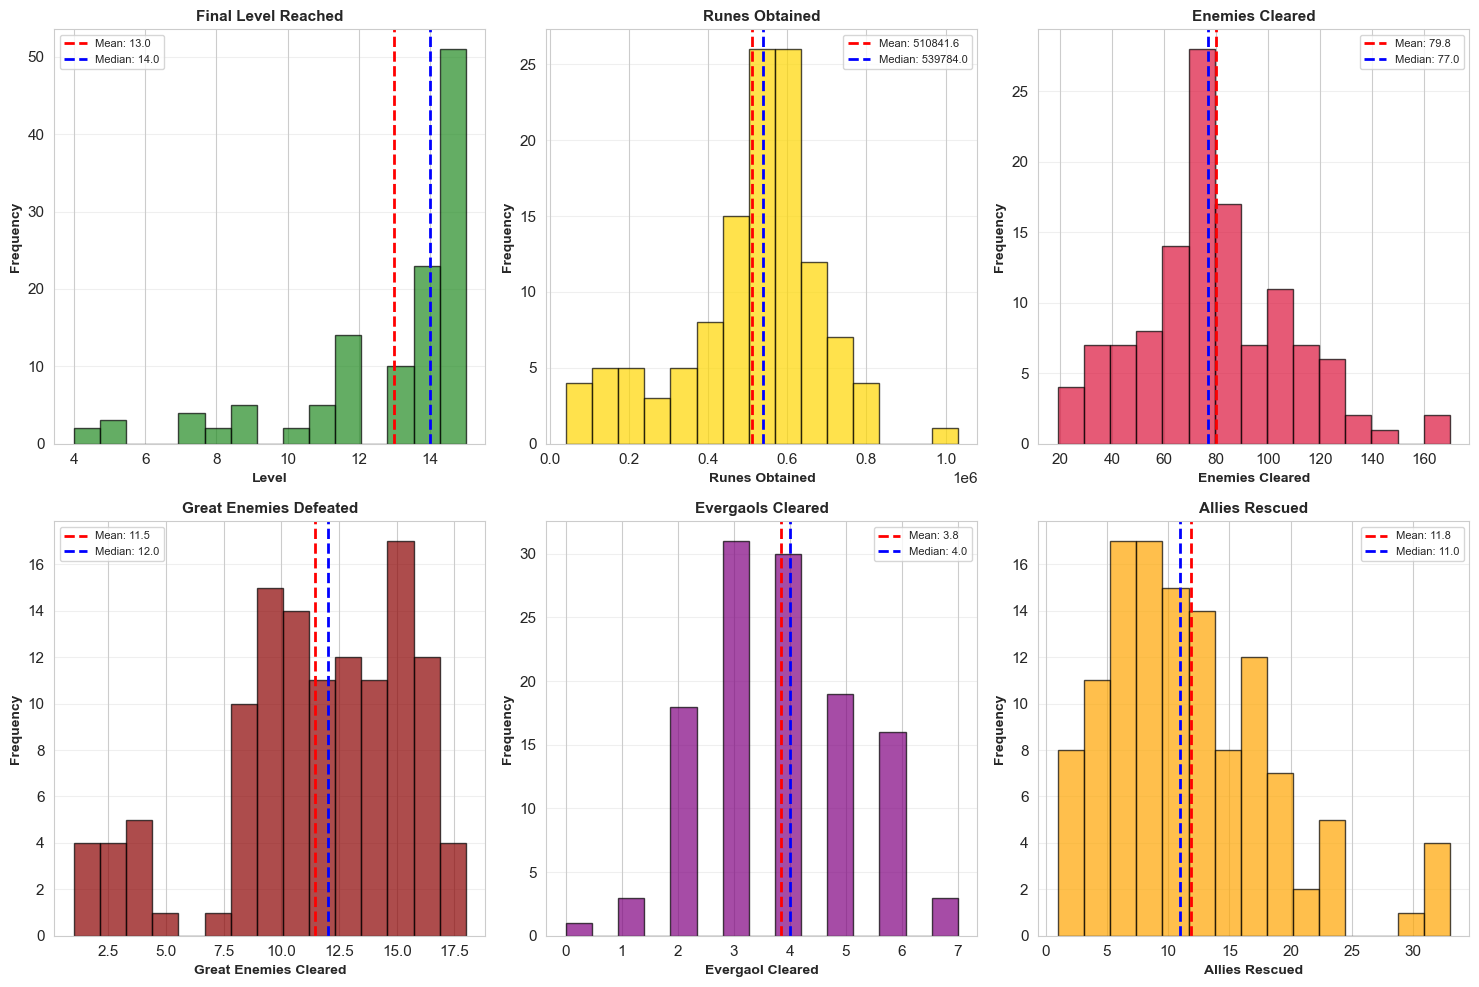

In [43]:
print("3.1 DISTRIBUTION ANALYSIS")

# --- PLOT 1: Run Outcome Distribution ---
print("\n Plot 1: Run Outcome Distribution")

fig, ax = plt.subplots(figsize=(10, 6))

# Count outcomes
outcome_counts = df['run_outcome'].value_counts()
outcome_order = ['first_day', 'second_day', 'final_day', 'victory']
outcome_counts = outcome_counts.reindex(outcome_order)

# Create bar plot
colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']
bars = ax.bar(range(len(outcome_counts)), outcome_counts.values, color=colors, alpha=0.8, edgecolor='black')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, outcome_counts.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val}\n({val/len(df)*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=12)

ax.set_xlabel('Run Outcome', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Runs', fontsize=13, fontweight='bold')
ax.set_title('Distribution of Run Outcomes (N=96)', fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(range(len(outcome_counts)))
ax.set_xticklabels(['First Day\n(Worst)', 'Second Day', 'Final Day\n(Reached Boss)', 'Victory\n(Best)'])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/01_outcome_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Key insights
victory_rate = df['victory_binary'].mean() * 100
reached_boss = ((df['run_outcome'] == 'final_day') | (df['run_outcome'] == 'victory')).mean() * 100
print(f"\n💡 Key Insights:")
print(f"   • Victory rate: {victory_rate:.1f}%")
print(f"   • Reached Nightlord (final_day + victory): {reached_boss:.1f}%")
print(f"   • Most common outcome: {outcome_counts.idxmax()} ({outcome_counts.max()} runs)")

# --- PLOT 2: Character Usage and Performance ---
print("\n Plot 2: Character Usage and Performance")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Character usage
char_counts = df['character'].value_counts()
ax1.pie(char_counts.values, labels=char_counts.index, autopct='%1.1f%%',
        startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title('Character Usage Distribution', fontsize=13, fontweight='bold', pad=15)

# Right: Win rate by character
char_winrate = df.groupby('character')['victory_binary'].agg(['mean', 'count'])
char_winrate['mean'] *= 100  # Convert to percentage

bars = ax2.bar(char_winrate.index, char_winrate['mean'], alpha=0.8, edgecolor='black')
ax2.set_xlabel('Character', fontsize=12, fontweight='bold')
ax2.set_ylabel('Victory Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Victory Rate by Character', fontsize=13, fontweight='bold', pad=15)
ax2.set_ylim(0, 100)
ax2.grid(axis='y', alpha=0.3)

# Add sample size labels
for i, (char, row) in enumerate(char_winrate.iterrows()):
    ax2.text(i, row['mean'] + 2, f"n={int(row['count'])}", 
             ha='center', fontsize=10, style='italic')
    ax2.text(i, row['mean']/2, f"{row['mean']:.1f}%", 
             ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('../results/figures/02_character_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Key Insights:")
print(f"   • Most played character: {char_counts.idxmax()} ({char_counts.max()} runs)")
print(f"   • Highest win rate: {char_winrate['mean'].idxmax()} ({char_winrate['mean'].max():.1f}%)")
print(f"   • Lowest win rate: {char_winrate['mean'].idxmin()} ({char_winrate['mean'].min():.1f}%)")

# --- PLOT 3: Difficulty Distribution ---
print("\n Plot 3: Difficulty Distribution and Performance")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Difficulty distribution
diff_counts = df['difficulty'].value_counts().sort_index()
ax1.bar(range(len(diff_counts)), diff_counts.values, color='steelblue', alpha=0.8, edgecolor='black')
ax1.set_xlabel('Difficulty Level', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Runs', fontsize=12, fontweight='bold')
ax1.set_title('Distribution Across Difficulty Levels', fontsize=13, fontweight='bold', pad=15)
ax1.set_xticks(range(len(diff_counts)))
ax1.set_xticklabels(diff_counts.index, rotation=45)
ax1.grid(axis='y', alpha=0.3)

for i, val in enumerate(diff_counts.values):
    ax1.text(i, val + 1, str(val), ha='center', fontweight='bold')

# Right: Win rate by difficulty
diff_winrate = df.groupby('difficulty_ordinal')['victory_binary'].mean() * 100
diff_counts_ord = df.groupby('difficulty_ordinal').size()

ax2.plot(diff_winrate.index, diff_winrate.values, marker='o', linewidth=3, 
         markersize=10, color='crimson', label='Win Rate')
ax2.set_xlabel('Difficulty Level (1=Easiest, 5=Hardest)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Victory Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Performance Across Difficulty Levels', fontsize=13, fontweight='bold', pad=15)
ax2.set_xticks(diff_winrate.index)
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3)
ax2.legend()

# Add data labels
for x, y, n in zip(diff_winrate.index, diff_winrate.values, diff_counts_ord.values):
    ax2.text(x, y + 3, f'{y:.1f}%\n(n={n})', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/03_difficulty_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Key Insights:")
print(f"   • Most common difficulty: Depth {diff_counts.idxmax()[-1]} ({diff_counts.max()} runs)")
print(f"   • Win rate trend: {diff_winrate.values[0]:.1f}% → {diff_winrate.values[-1]:.1f}%")

# --- PLOT 4: Continuous Variables Distribution ---
print("\n Plot 4: Distribution of Performance Metrics")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

metrics = [
    ('level', 'Final Level Reached', 'forestgreen'),
    ('runes_obtained', 'Runes Obtained', 'gold'),
    ('enemies_cleared', 'Enemies Cleared', 'crimson'),
    ('great_enemies_cleared', 'Great Enemies Defeated', 'darkred'),
    ('evergaol_cleared', 'Evergaols Cleared', 'purple'),
    ('allies_rescued', 'Allies Rescued', 'orange')
]

for ax, (col, title, color) in zip(axes, metrics):
    ax.hist(df[col], bins=15, color=color, alpha=0.7, edgecolor='black')
    ax.axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[col].mean():.1f}')
    ax.axvline(df[col].median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {df[col].median():.1f}')
    ax.set_xlabel(col.replace('_', ' ').title(), fontsize=10, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=10, fontweight='bold')
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/04_continuous_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


# 2.2 RELATIONSHIP ANALYSIS
This section explores how different gameplay variables relate to one another and how these relationships translate into performance differences.
By combining correlation analysis, behavioral trends, and strategic decision comparisons, we identify which factors most strongly influence progression, victory probability, and overall run efficiency.
These visual and statistical summaries reveal meaningful patterns—such as warm-up effects, optimal resource investment, and team composition advantages—that guide later modeling and interpretation.

3.2 RELATIONSHIP ANALYSIS

 Plot 5: Correlation Heatmap (Numeric Features)


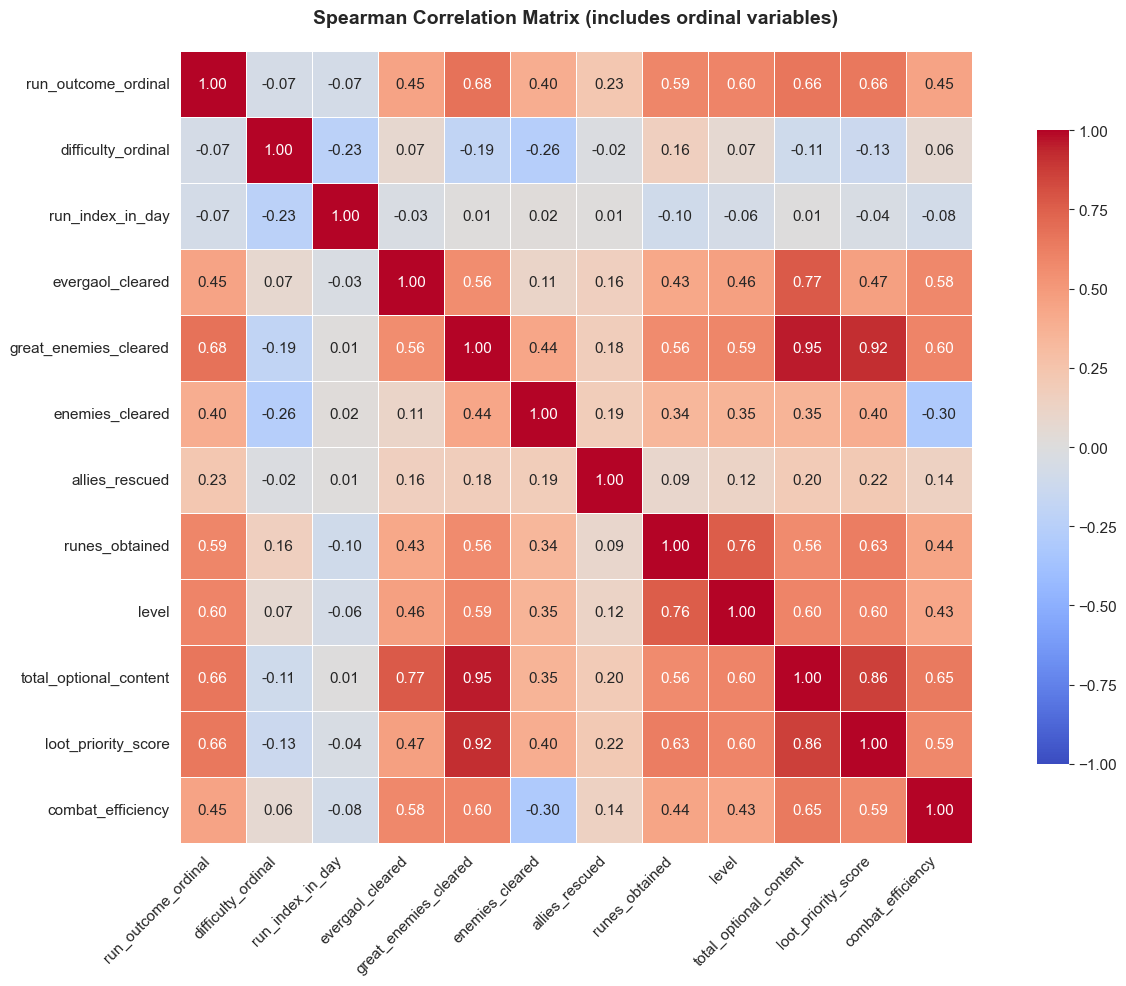


 Top 5 Correlations with Run Outcome:
   • great_enemies_cleared: 0.677
   • total_optional_content: 0.661
   • loot_priority_score: 0.656
   • level: 0.598
   • runes_obtained: 0.592

 Plot 6: Warm-up Effect - Performance by Run Index


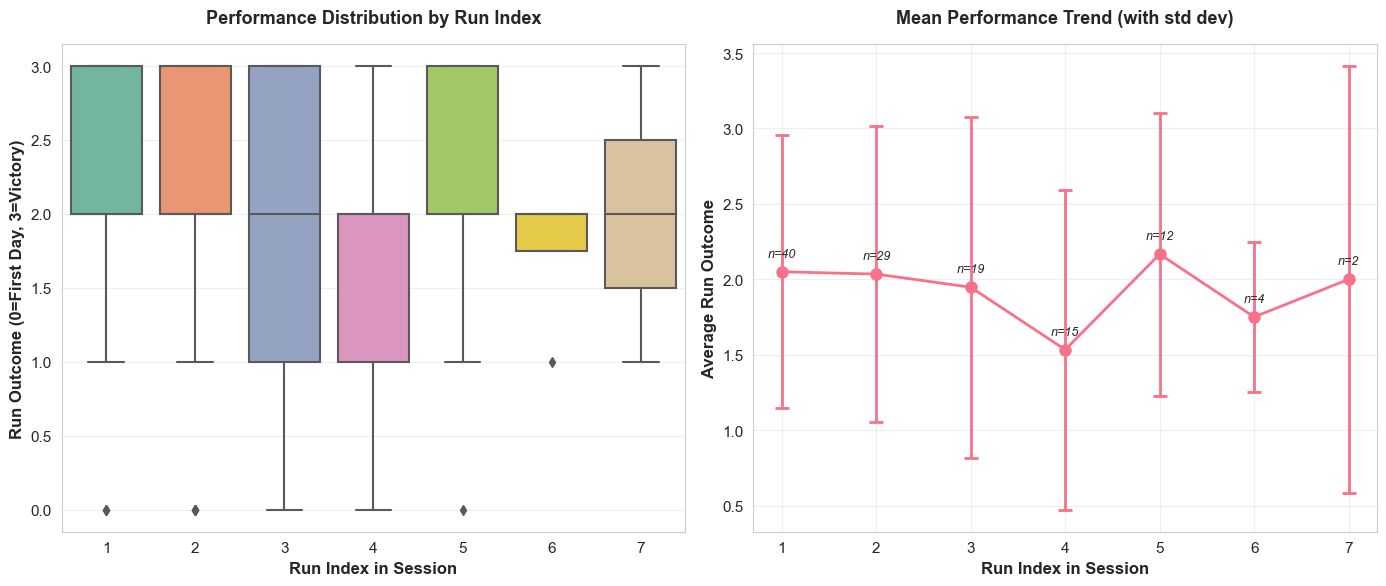


 Key Insights:
   • First run average outcome: 2.05
   • Later runs average outcome: 1.93
   • Difference: -0.12

 Plot 7: Resource Allocation - Evergaols vs Great Enemies


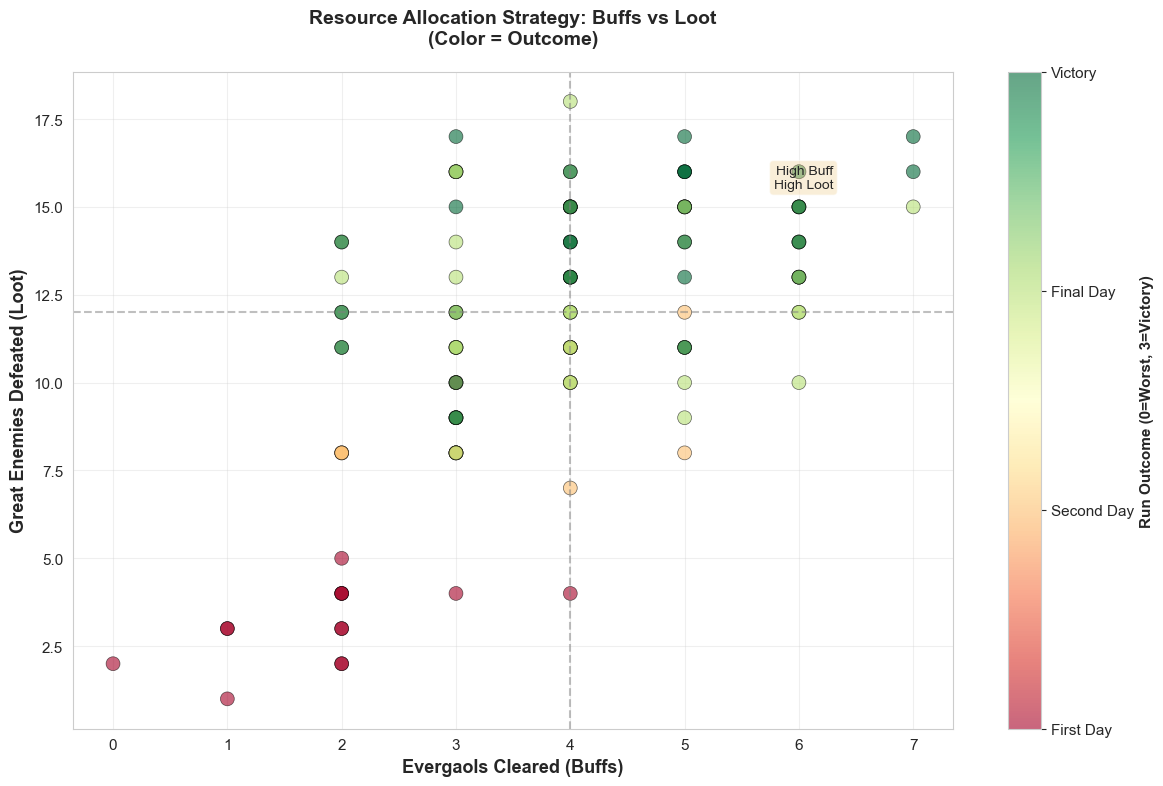


 Plot 8: Middle Castle Visit Impact


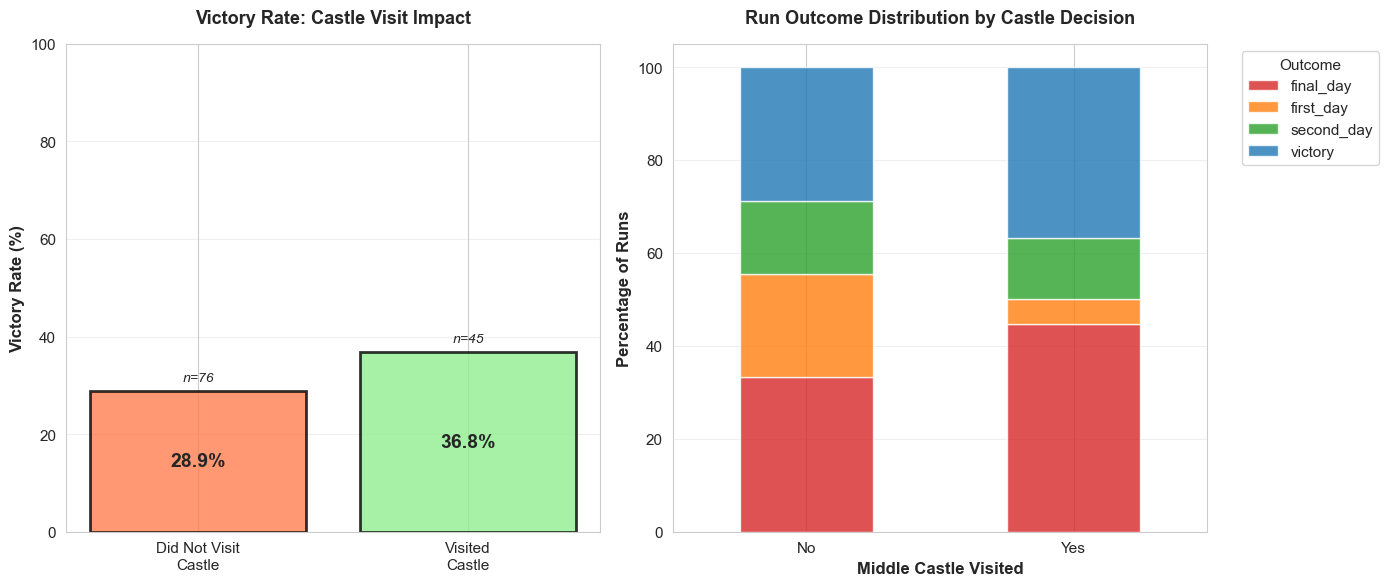


 Key Insights:
   • Win rate WITHOUT castle: 28.9%
   • Win rate WITH castle: 36.8%
   • Difference: +8.0 percentage points

 Plot 9: Evergaol Clearing - Finding the Sweet Spot


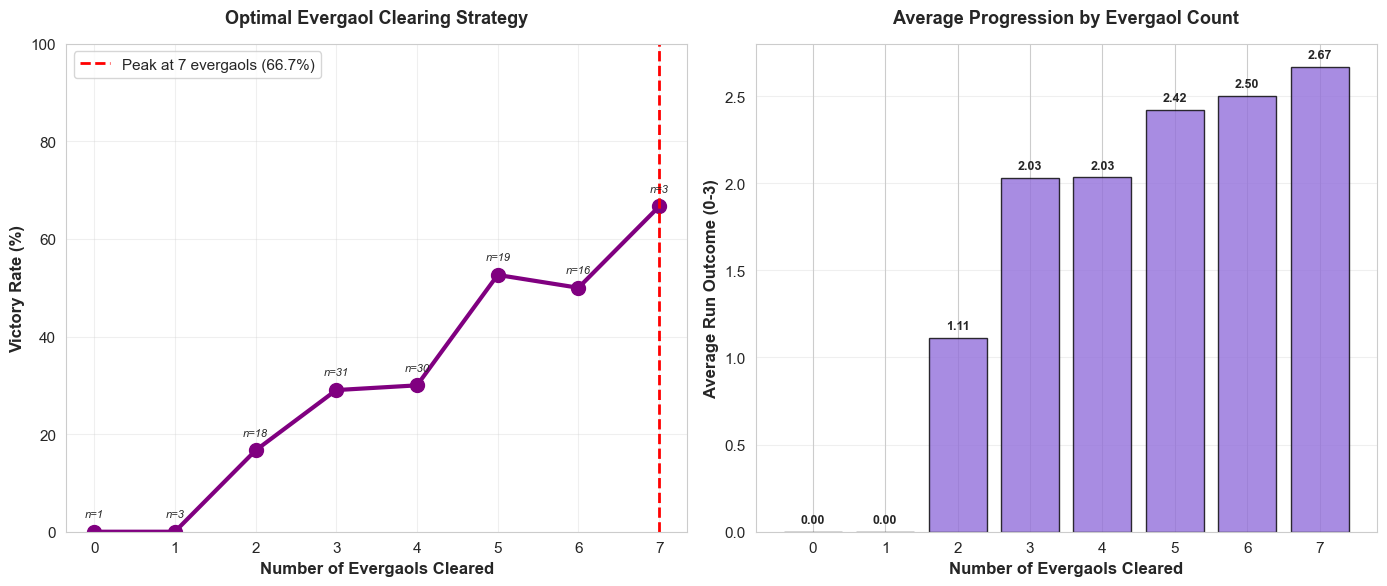


 Key Insights:
   • Optimal evergaol count: 7 (win rate: 66.7%)
   • Clearing 0 evergaols: 0.0% win rate
   • Clearing 7 evergaols: 66.7% win rate

 Plot 10: Team Composition Impact


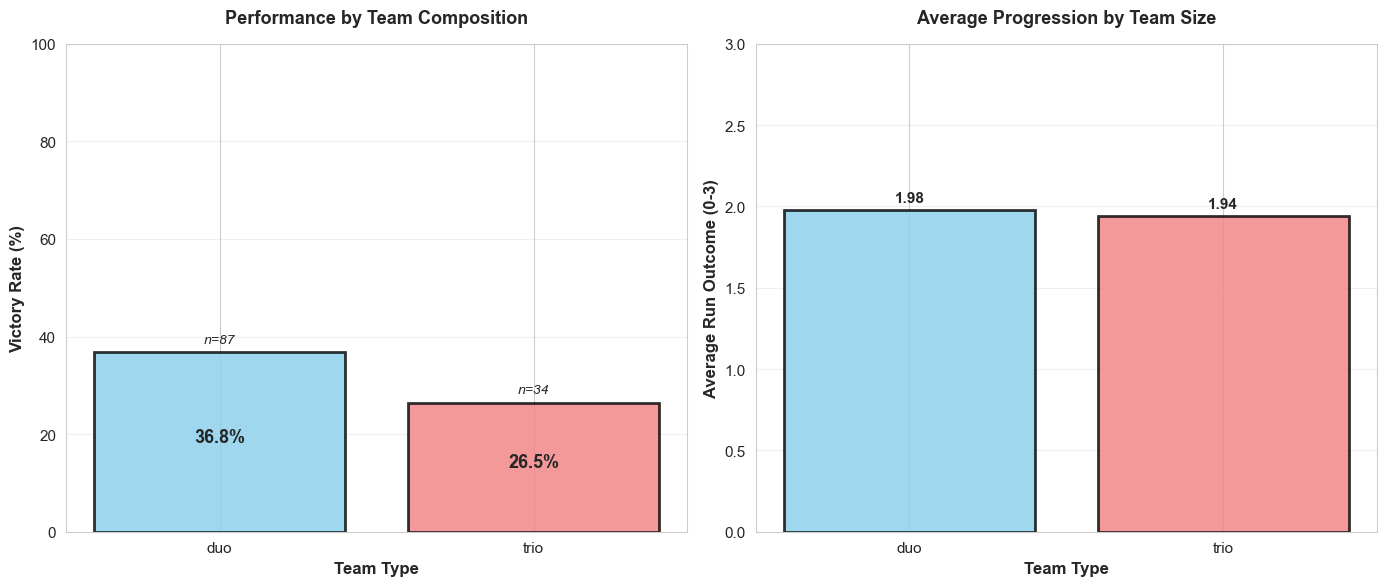

In [44]:
print("3.2 RELATIONSHIP ANALYSIS")

# --- PLOT 5: Correlation Heatmap ---
print("\n Plot 5: Correlation Heatmap (Numeric Features)")

# Select numeric columns
numeric_cols = [
    'run_outcome_ordinal', 'difficulty_ordinal', 'run_index_in_day',
    'evergaol_cleared', 'great_enemies_cleared', 'enemies_cleared',
    'allies_rescued', 'runes_obtained', 'level',
    'total_optional_content', 'loot_priority_score', 'combat_efficiency'
]

corr_matrix = df[numeric_cols].corr(method='spearman')

fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)
ax.set_title('Spearman Correlation Matrix (includes ordinal variables)', 
             fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../results/figures/05_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Top correlations with outcome
outcome_corr = corr_matrix['run_outcome_ordinal'].sort_values(ascending=False)
print(f"\n Top 5 Correlations with Run Outcome:")
for var, corr in outcome_corr.head(6).items():
    if var != 'run_outcome_ordinal':
        print(f"   • {var}: {corr:.3f}")

# --- PLOT 6: Warm-up Effect Analysis ---
print("\n Plot 6: Warm-up Effect - Performance by Run Index")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Box plot
sns.boxplot(data=df, x='run_index_in_day', y='run_outcome_ordinal', ax=ax1, palette='Set2')
ax1.set_xlabel('Run Index in Session', fontsize=12, fontweight='bold')
ax1.set_ylabel('Run Outcome (0=First Day, 3=Victory)', fontsize=12, fontweight='bold')
ax1.set_title('Performance Distribution by Run Index', fontsize=13, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3)

# Right: Line plot with error bars
run_perf = df.groupby('run_index_in_day')['run_outcome_ordinal'].agg(['mean', 'std', 'count'])
ax2.errorbar(run_perf.index, run_perf['mean'], yerr=run_perf['std'], 
             marker='o', linewidth=2, markersize=8, capsize=5, capthick=2)
ax2.set_xlabel('Run Index in Session', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Run Outcome', fontsize=12, fontweight='bold')
ax2.set_title('Mean Performance Trend (with std dev)', fontsize=13, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3)

# Add sample sizes
for idx, row in run_perf.iterrows():
    ax2.text(idx, row['mean'] + 0.1, f"n={int(row['count'])}", 
             ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.savefig('../results/figures/06_warmup_effect.png', dpi=300, bbox_inches='tight')
plt.show()

first_run_avg = df[df['run_index_in_day'] == 1]['run_outcome_ordinal'].mean()
later_runs_avg = df[df['run_index_in_day'] > 1]['run_outcome_ordinal'].mean()
print(f"\n Key Insights:")
print(f"   • First run average outcome: {first_run_avg:.2f}")
print(f"   • Later runs average outcome: {later_runs_avg:.2f}")
print(f"   • Difference: {later_runs_avg - first_run_avg:+.2f}")

# --- PLOT 7: Resource Allocation - Evergaols vs Great Enemies ---
print("\n Plot 7: Resource Allocation - Evergaols vs Great Enemies")

fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot with outcome as color
scatter = ax.scatter(df['evergaol_cleared'], df['great_enemies_cleared'], 
                     c=df['run_outcome_ordinal'], s=100, alpha=0.6, 
                     cmap='RdYlGn', edgecolor='black', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Run Outcome (0=Worst, 3=Victory)', fontsize=11, fontweight='bold')
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(['First Day', 'Second Day', 'Final Day', 'Victory'])

ax.set_xlabel('Evergaols Cleared (Buffs)', fontsize=13, fontweight='bold')
ax.set_ylabel('Great Enemies Defeated (Loot)', fontsize=13, fontweight='bold')
ax.set_title('Resource Allocation Strategy: Buffs vs Loot\n(Color = Outcome)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)

# Add quadrant lines
ax.axhline(df['great_enemies_cleared'].median(), color='gray', linestyle='--', alpha=0.5)
ax.axvline(df['evergaol_cleared'].median(), color='gray', linestyle='--', alpha=0.5)

# Add quadrant labels
ax.text(df['evergaol_cleared'].max() * 0.9, df['great_enemies_cleared'].max() * 0.9,
        'High Buff\nHigh Loot', ha='right', va='top', fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../results/figures/07_resource_allocation_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# --- PLOT 8: Middle Castle Impact ---
print("\n Plot 8: Middle Castle Visit Impact")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Win rate comparison
castle_winrate = df.groupby('middle_castle_visited')['victory_binary'].mean() * 100
castle_counts = df['middle_castle_visited'].value_counts()

bars = ax1.bar(['Did Not Visit\nCastle', 'Visited\nCastle'], 
               [castle_winrate[False], castle_winrate[True]], 
               color=['coral', 'lightgreen'], alpha=0.8, edgecolor='black', linewidth=2)

for i, (bar, rate, count) in enumerate(zip(bars, castle_winrate.values, castle_counts.values)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height/2,
             f'{rate:.1f}%', ha='center', va='center', fontweight='bold', fontsize=14)
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'n={count}', ha='center', fontsize=10, style='italic')

ax1.set_ylabel('Victory Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Victory Rate: Castle Visit Impact', fontsize=13, fontweight='bold', pad=15)
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3)

# Right: Outcome distribution
outcome_by_castle = pd.crosstab(df['middle_castle_visited'], df['run_outcome'], normalize='index') * 100
outcome_by_castle.plot(kind='bar', stacked=True, ax=ax2, 
                       color=['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4'], alpha=0.8)
ax2.set_xlabel('Middle Castle Visited', fontsize=12, fontweight='bold')
ax2.set_ylabel('Percentage of Runs', fontsize=12, fontweight='bold')
ax2.set_title('Run Outcome Distribution by Castle Decision', fontsize=13, fontweight='bold', pad=15)
ax2.set_xticklabels(['No', 'Yes'], rotation=0)
ax2.legend(title='Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/08_castle_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Key Insights:")
print(f"   • Win rate WITHOUT castle: {castle_winrate[False]:.1f}%")
print(f"   • Win rate WITH castle: {castle_winrate[True]:.1f}%")
print(f"   • Difference: {castle_winrate[True] - castle_winrate[False]:+.1f} percentage points")

# --- PLOT 9: Evergaol Optimization ---
print("\n Plot 9: Evergaol Clearing - Finding the Sweet Spot")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Win rate by evergaol count
evergaol_winrate = df.groupby('evergaol_cleared')['victory_binary'].mean() * 100
evergaol_counts = df.groupby('evergaol_cleared').size()

ax1.plot(evergaol_winrate.index, evergaol_winrate.values, 
         marker='o', linewidth=3, markersize=10, color='purple')
ax1.set_xlabel('Number of Evergaols Cleared', fontsize=12, fontweight='bold')
ax1.set_ylabel('Victory Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Optimal Evergaol Clearing Strategy', fontsize=13, fontweight='bold', pad=15)
ax1.set_xticks(range(8))
ax1.set_ylim(0, 100)
ax1.grid(True, alpha=0.3)

# Mark optimal point
optimal_count = evergaol_winrate.idxmax()
ax1.axvline(optimal_count, color='red', linestyle='--', linewidth=2, 
            label=f'Peak at {optimal_count} evergaols ({evergaol_winrate.max():.1f}%)')
ax1.legend()

# Add sample sizes
for x, y, n in zip(evergaol_winrate.index, evergaol_winrate.values, evergaol_counts.values):
    ax1.text(x, y + 3, f'n={n}', ha='center', fontsize=8, style='italic')

# Right: Average outcome by evergaol count
evergaol_outcome = df.groupby('evergaol_cleared')['run_outcome_ordinal'].mean()

ax2.bar(evergaol_outcome.index, evergaol_outcome.values, 
        color='mediumpurple', alpha=0.8, edgecolor='black')
ax2.set_xlabel('Number of Evergaols Cleared', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Run Outcome (0-3)', fontsize=12, fontweight='bold')
ax2.set_title('Average Progression by Evergaol Count', fontsize=13, fontweight='bold', pad=15)
ax2.set_xticks(range(8))
ax2.grid(axis='y', alpha=0.3)

for x, y in zip(evergaol_outcome.index, evergaol_outcome.values):
    ax2.text(x, y + 0.05, f'{y:.2f}', ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('../results/figures/09_evergaol_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Key Insights:")
print(f"   • Optimal evergaol count: {optimal_count} (win rate: {evergaol_winrate.max():.1f}%)")
print(f"   • Clearing 0 evergaols: {evergaol_winrate.get(0, 0):.1f}% win rate")
print(f"   • Clearing 7 evergaols: {evergaol_winrate.get(7, 0):.1f}% win rate")

# --- PLOT 10: Team Composition Analysis ---
print("\n Plot 10: Team Composition Impact")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Win rate by team type
team_stats = df.groupby('team_type').agg({
    'victory_binary': 'mean',
    'run_id': 'count'
}).rename(columns={'victory_binary': 'win_rate', 'run_id': 'count'})
team_stats['win_rate'] *= 100

bars = ax1.bar(team_stats.index, team_stats['win_rate'], 
               color=['skyblue', 'lightcoral', 'lightgreen'][:len(team_stats)], 
               alpha=0.8, edgecolor='black', linewidth=2)

for bar, (idx, row) in zip(bars, team_stats.iterrows()):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height/2,
             f'{row["win_rate"]:.1f}%', ha='center', fontweight='bold', fontsize=13)
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'n={int(row["count"])}', ha='center', fontsize=10, style='italic')

ax1.set_ylabel('Victory Rate (%)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Team Type', fontsize=12, fontweight='bold')
ax1.set_title('Performance by Team Composition', fontsize=13, fontweight='bold', pad=15)
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3)

# Right: Average outcome by team
team_outcome = df.groupby('team_type')['run_outcome_ordinal'].mean()

ax2.bar(team_outcome.index, team_outcome.values, 
        color=['skyblue', 'lightcoral', 'lightgreen'][:len(team_outcome)], 
        alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_ylabel('Average Run Outcome (0-3)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Team Type', fontsize=12, fontweight='bold')
ax2.set_title('Average Progression by Team Size', fontsize=13, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 3)

for i, (team, outcome) in enumerate(team_outcome.items()):
    ax2.text(i, outcome + 0.05, f'{outcome:.2f}', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('../results/figures/10_team_composition.png', dpi=300, bbox_inches='tight')
plt.show()


# 2.3 STRATEGIC ANALYSIS
This section evaluates how different strategic choices influence run performance.
By examining win rates, usage patterns, and interactions with difficulty, we identify which strategies are most effective, how flexible strategy selection is across difficulty levels, and how special conditions—such as enhanced Nightlord encounters—affect outcomes.
These analyses reveal the tactical decisions that contribute most to success and highlight situational advantages or disadvantages within the game’s strategic landscape.


3.4 STRATEGIC ANALYSIS

 Plot 13: Performance by Strategy Type


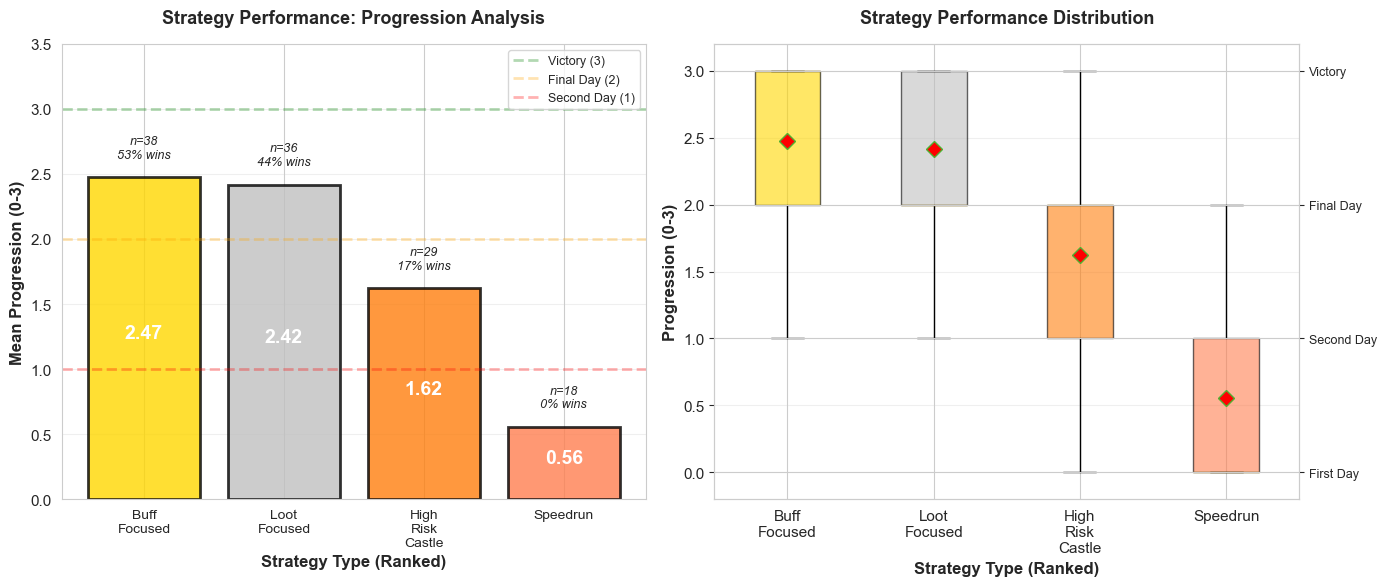


 Key Insights:
   📊 RANKED BY PROGRESSION:
   1. Buff Focused        : Mean = 2.474, Win Rate =  52.6%, n = 38
   2. Loot Focused        : Mean = 2.417, Win Rate =  44.4%, n = 36
   3. High Risk Castle    : Mean = 1.621, Win Rate =  17.2%, n = 29
   4. Speedrun            : Mean = 0.556, Win Rate =   0.0%, n = 18

   • Best strategy: Buff Focused (2.47 avg progression)
   • Worst strategy: Speedrun (0.56 avg progression)
   • Performance gap: 1.92 progression points

   ⚡ Speedrun analysis:
      Mean progression: 0.56 (rarely reaches victory)
      Win rate: 0.0% (very low, as expected)
      → Strategy barely reaches second day on average

 Plot 14: Strategy Adaptation Across Difficulties


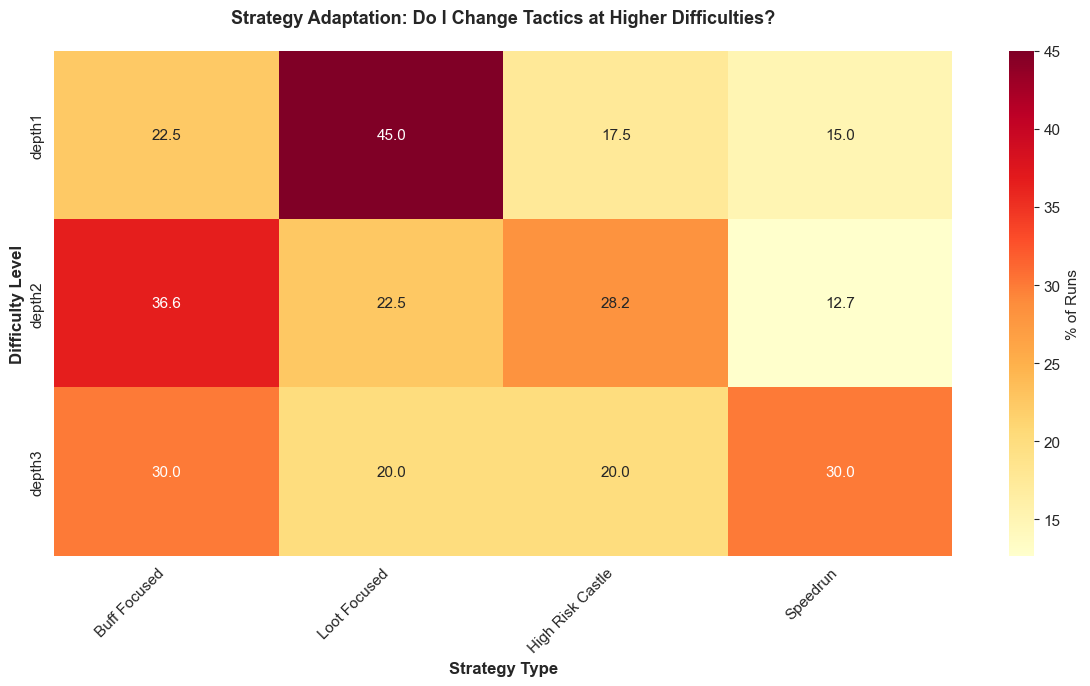


 Plot 15: Enhanced Nightlords Impact


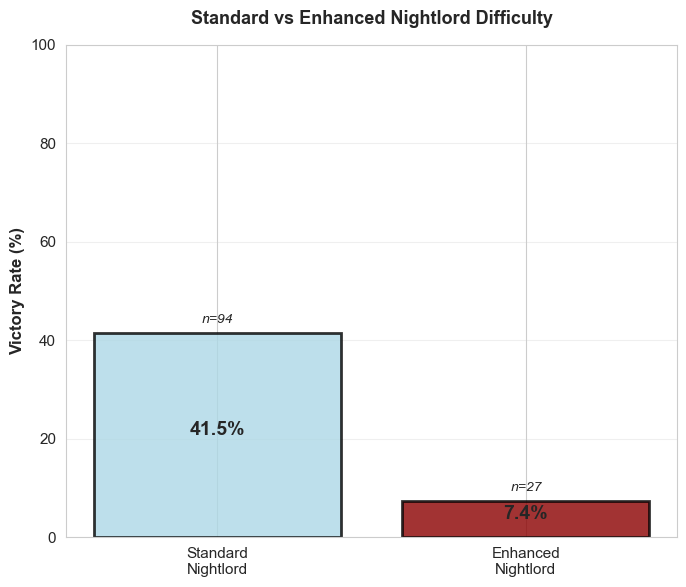


 Key Insights:
   • Standard Nightlord win rate: 41.5%
   • Enhanced Nightlord win rate: 7.4%
   • Difficulty increase: +34.1 percentage points


In [45]:
print("3.4 STRATEGIC ANALYSIS")

# --- PLOT 13: Strategy Type Performance (UPDATED) ---
print("\n Plot 13: Performance by Strategy Type")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Mean progression by strategy
strat_performance = df.groupby('strategy_type')['run_outcome_ordinal'].agg(['mean', 'std', 'count'])
strat_winrate = df.groupby('strategy_type')['victory_binary'].mean() * 100

# Sort by mean performance
strat_performance = strat_performance.sort_values('mean', ascending=False)

colors = ['gold' if i == 0 else 'silver' if i == 1 else '#ff7f0e' if i == 2 else 'coral' 
          for i in range(len(strat_performance))]

bars = ax1.bar(range(len(strat_performance)), strat_performance['mean'].values, 
               color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Add mean progression values
for i, (bar, (strat, row)) in enumerate(zip(bars, strat_performance.iterrows())):
    height = bar.get_height()
    # Mean progression in the middle
    ax1.text(bar.get_x() + bar.get_width()/2., height/2,
             f'{row["mean"]:.2f}', ha='center', fontweight='bold', fontsize=14, color='white')
    # Sample size and win rate above
    win_rate = strat_winrate[strat]
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.15,
             f'n={int(row["count"])}\n{win_rate:.0f}% wins', 
             ha='center', fontsize=9, style='italic')

ax1.set_xticks(range(len(strat_performance)))
ax1.set_xticklabels([s.replace('_', '\n').title() for s in strat_performance.index], 
                     rotation=0, fontsize=10)
ax1.set_ylabel('Mean Progression (0-3)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Strategy Type (Ranked)', fontsize=12, fontweight='bold')
ax1.set_title('Strategy Performance: Progression Analysis', fontsize=13, fontweight='bold', pad=15)
ax1.set_ylim(0, 3.5)
ax1.grid(axis='y', alpha=0.3)

# Add reference lines
ax1.axhline(y=3, color='green', linestyle='--', alpha=0.3, linewidth=2, label='Victory (3)')
ax1.axhline(y=2, color='orange', linestyle='--', alpha=0.3, linewidth=2, label='Final Day (2)')
ax1.axhline(y=1, color='red', linestyle='--', alpha=0.3, linewidth=2, label='Second Day (1)')
ax1.legend(loc='upper right', fontsize=9)

# Right: Box plots showing distribution
strat_order = strat_performance.index.tolist()
df['strategy_type'] = pd.Categorical(df['strategy_type'], categories=strat_order, ordered=True)

bp = ax2.boxplot([df[df['strategy_type'] == strat]['run_outcome_ordinal'].values 
                   for strat in strat_order],
                  labels=[s.replace('_', '\n').title() for s in strat_order],
                  patch_artist=True, showmeans=True, meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax2.set_ylabel('Progression (0-3)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Strategy Type (Ranked)', fontsize=12, fontweight='bold')
ax2.set_title('Strategy Performance Distribution', fontsize=13, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(-0.2, 3.2)

# Add outcome labels on right axis
ax2_right = ax2.twinx()
ax2_right.set_ylim(-0.2, 3.2)
ax2_right.set_yticks([0, 1, 2, 3])
ax2_right.set_yticklabels(['First Day', 'Second Day', 'Final Day', 'Victory'], fontsize=9)

plt.tight_layout()
plt.savefig('../results/figures/13_strategy_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Key Insights:")
print(f"   📊 RANKED BY PROGRESSION:")
for i, (strat, row) in enumerate(strat_performance.iterrows(), 1):
    win_rate = strat_winrate[strat]
    print(f"   {i}. {strat.replace('_', ' ').title():20s}: "
          f"Mean = {row['mean']:.3f}, Win Rate = {win_rate:5.1f}%, n = {int(row['count'])}")

best_strat = strat_performance.index[0]
worst_strat = strat_performance.index[-1]
print(f"\n   • Best strategy: {best_strat.replace('_', ' ').title()} "
      f"({strat_performance.loc[best_strat, 'mean']:.2f} avg progression)")
print(f"   • Worst strategy: {worst_strat.replace('_', ' ').title()} "
      f"({strat_performance.loc[worst_strat, 'mean']:.2f} avg progression)")
print(f"   • Performance gap: {strat_performance.loc[best_strat, 'mean'] - strat_performance.loc[worst_strat, 'mean']:.2f} progression points")

# Additional insight about speedrun
if 'speedrun' in strat_performance.index:
    speedrun_mean = strat_performance.loc['speedrun', 'mean']
    speedrun_wins = strat_winrate['speedrun']
    print(f"\n   ⚡ Speedrun analysis:")
    print(f"      Mean progression: {speedrun_mean:.2f} (rarely reaches victory)")
    print(f"      Win rate: {speedrun_wins:.1f}% (very low, as expected)")
    if speedrun_mean < 1.0:
        print(f"      → Strategy barely reaches second day on average")

# --- PLOT 14: Difficulty × Strategy Interaction ---
print("\n Plot 14: Strategy Adaptation Across Difficulties")

fig, ax = plt.subplots(figsize=(12, 7))

# Heatmap of strategy usage by difficulty
strategy_diff = pd.crosstab(df['difficulty'], df['strategy_type'], normalize='index') * 100

sns.heatmap(strategy_diff, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': '% of Runs'}, ax=ax)
ax.set_xlabel('Strategy Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Difficulty Level', fontsize=12, fontweight='bold')
ax.set_title('Strategy Adaptation: Do I Change Tactics at Higher Difficulties?', 
             fontsize=13, fontweight='bold', pad=20)
ax.set_xticklabels([s.replace('_', ' ').title() for s in strategy_diff.columns], rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../results/figures/14_difficulty_strategy_interaction.png', dpi=300, bbox_inches='tight')
plt.show()

# --- PLOT 15: Enhanced Nightlords Analysis ---
print("\n Plot 15: Enhanced Nightlords Impact")

if 'enhanced' in df.columns and df['enhanced'].sum() > 0:
    fig, ax1 = plt.subplots(figsize=(7, 6))
    
    # Left: Win rate comparison
    enhanced_winrate = df.groupby('enhanced')['victory_binary'].mean() * 100
    enhanced_counts = df['enhanced'].value_counts()
    
    bars = ax1.bar(['Standard\nNightlord', 'Enhanced\nNightlord'], 
                   [enhanced_winrate[False], enhanced_winrate[True]], 
                   color=['lightblue', 'darkred'], alpha=0.8, edgecolor='black', linewidth=2)
    
    for i, (bar, rate) in enumerate(zip(bars, enhanced_winrate.values)):
        height = bar.get_height()
        count = enhanced_counts.iloc[i]
        ax1.text(bar.get_x() + bar.get_width()/2., height/2,
                 f'{rate:.1f}%', ha='center', fontweight='bold', fontsize=14)
        ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                 f'n={count}', ha='center', fontsize=10, style='italic')
    
    ax1.set_ylabel('Victory Rate (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Standard vs Enhanced Nightlord Difficulty', fontsize=13, fontweight='bold', pad=15)
    ax1.set_ylim(0, 100)
    ax1.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/figures/15_enhanced_nightlords.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n Key Insights:")
    print(f"   • Standard Nightlord win rate: {enhanced_winrate[False]:.1f}%")
    print(f"   • Enhanced Nightlord win rate: {enhanced_winrate[True]:.1f}%")
    print(f"   • Difficulty increase: {enhanced_winrate[False] - enhanced_winrate[True]:+.1f} percentage points")
else:
    print("     Not enough enhanced Nightlord data to analyze")


# 2.4 EDA SUMMARY
This final section consolidates the major findings from the exploratory data analysis.
It highlights overall performance metrics, character effectiveness, difficulty trends, strategic decision impacts, and session-level patterns.
By summarizing the most influential factors—such as optimal evergaol investment, castle visit effects, warm-up improvements, and best-performing strategies—this section provides a clear, high-level overview of what drives success in the dataset and forms a foundation for deeper statistical modeling or machine learning predictions.

In [46]:
print("EDA SUMMARY - KEY FINDINGS")

summary = f"""
 OVERALL PERFORMANCE:
   • Total runs analyzed: {len(df)}
   • Overall victory rate: {df['victory_binary'].mean()*100:.1f}%
   • Average run outcome: {df['run_outcome_ordinal'].mean():.2f}/3.0
   
 CHARACTER INSIGHTS:
   • Most played: {df['character'].mode()[0]} ({df['character'].value_counts().max()} runs)
   • Best performer: {char_winrate['mean'].idxmax()} ({char_winrate['mean'].max():.1f}% win rate)
   
 DIFFICULTY PROGRESSION:
   • Most common difficulty: {diff_counts.idxmax()}
   • Win rate at lowest difficulty: {diff_winrate.iloc[0]:.1f}%
   • Win rate at highest difficulty: {diff_winrate.iloc[-1]:.1f}%
   
 STRATEGIC DECISIONS:
   • Optimal evergaol count: {optimal_count} evergaols
   • Castle visit impact: {castle_winrate[True] - castle_winrate[False]:+.1f} percentage points
   • Best strategy type: {strat_winrate.idxmax()} ({strat_winrate.max():.1f}% win rate)
   
 WARM-UP EFFECT:
   • First run performance: {first_run_avg:.2f}/3.0
   • Later runs performance: {later_runs_avg:.2f}/3.0
   • Improvement: {later_runs_avg - first_run_avg:+.2f}
   
 TEAM COMPOSITION:
   • Best team size: {team_stats['win_rate'].idxmax()} ({team_stats['win_rate'].max():.1f}% win rate)
"""

print(summary)

EDA SUMMARY - KEY FINDINGS

 OVERALL PERFORMANCE:
   • Total runs analyzed: 121
   • Overall victory rate: 33.9%
   • Average run outcome: 1.97/3.0
   
 CHARACTER INSIGHTS:
   • Most played: recluse (51 runs)
   • Best performer: guardian (57.1% win rate)
   
 DIFFICULTY PROGRESSION:
   • Most common difficulty: depth2
   • Win rate at lowest difficulty: 35.0%
   • Win rate at highest difficulty: 20.0%
   
 STRATEGIC DECISIONS:
   • Optimal evergaol count: 7 evergaols
   • Castle visit impact: +8.0 percentage points
   • Best strategy type: buff_focused (52.6% win rate)
   
 WARM-UP EFFECT:
   • First run performance: 2.05/3.0
   • Later runs performance: 1.93/3.0
   • Improvement: -0.12
   
 TEAM COMPOSITION:
   • Best team size: duo (36.8% win rate)



# SECTION 3: HYPOTHESIS TESTING
This section focuses on OPTIMIZING gameplay strategy through
statistical analysis of resource allocation decisions.

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import (mannwhitneyu, kruskal, chi2_contingency, 
                         spearmanr, f_oneway)
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# 3.1 TEST 1: WARM-UP EFFECT
This section tests whether performance improves after the first run of each gaming session.
Using a two-group comparison between “first runs” and “later runs,” we evaluate both descriptive differences and statistical significance using the Mann–Whitney U test, which is appropriate for ordinal outcome data.
The analysis quantifies the size of the improvement (or decline), examines victory rates for context, and visualizes the pattern through box plots and mean-trend graphs.
This provides a clear answer to whether a warm-up effect exists and whether players should expect better results after the initial run(s).


TEST 1: SESSION PROGRESSION EFFECTS - WARM-UP AND FATIGUE

📋 Research Question:
   How does performance change across a gaming session?
   Is there evidence of warm-up benefits and/or fatigue costs?

📊 Hypotheses:
   H₀: Performance remains constant across run indices within a session
       (no warm-up or fatigue effects)
   H₁: Performance varies significantly across run indices
       (warm-up improves performance and/or fatigue declines it)

📊 Performance by Run Index in Session:
   Run  1: Mean = 2.050, Win Rate =  35.0%, n = 40
   Run  2: Mean = 2.034, Win Rate =  34.5%, n = 29
   Run  3: Mean = 1.947, Win Rate =  42.1%, n = 19
   Run  4: Mean = 1.533, Win Rate =  20.0%, n = 15
   Run  5: Mean = 2.167, Win Rate =  41.7%, n = 12
   Run  6: Mean = 1.750, Win Rate =   0.0%, n = 4
   Run  7: Mean = 2.000, Win Rate =  50.0%, n = 2

📊 Session Segments:
   First (Run 1):     Mean = 2.050, n = 40
   Early (Runs 2-3):  Mean = 2.000, n = 48
   Mid (Runs 4-5):    Mean = 1.815, n = 27
   La

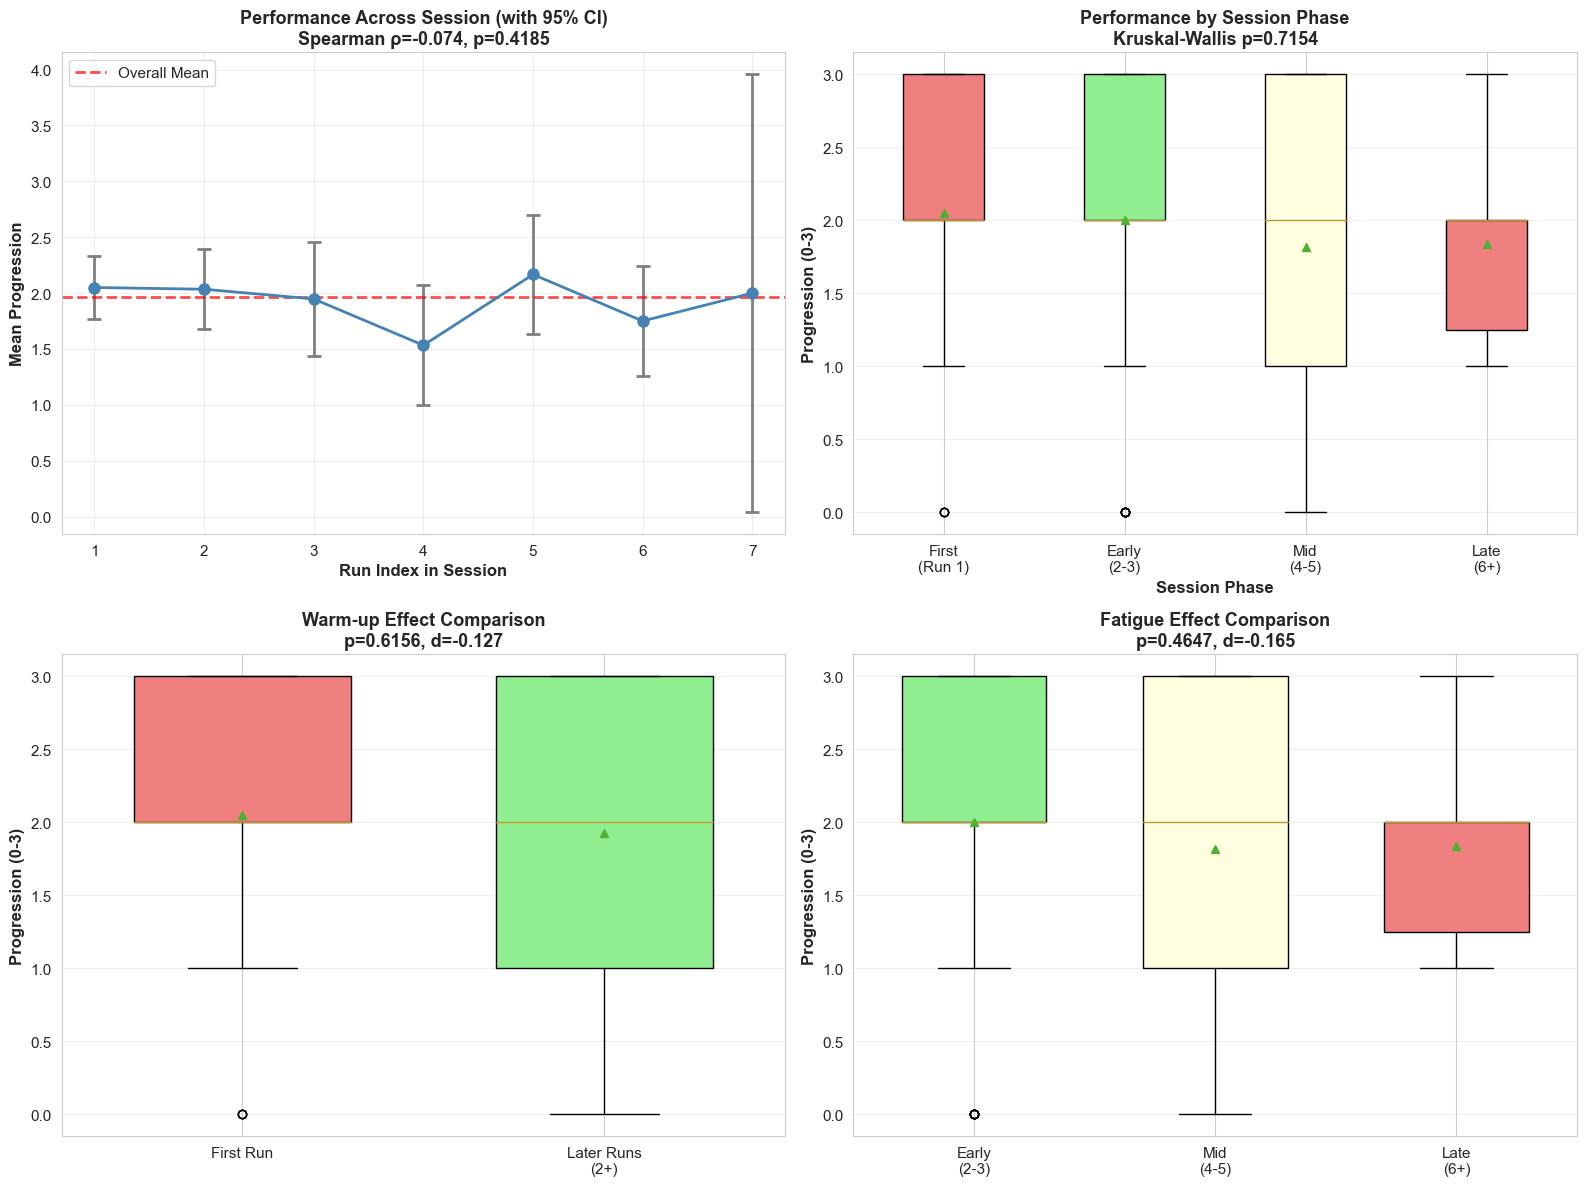

In [48]:
print("\n" + "="*70)
print("TEST 1: SESSION PROGRESSION EFFECTS - WARM-UP AND FATIGUE")
print("="*70)

print("\n📋 Research Question:")
print("   How does performance change across a gaming session?")
print("   Is there evidence of warm-up benefits and/or fatigue costs?")

print("\n📊 Hypotheses:")
print("   H₀: Performance remains constant across run indices within a session")
print("       (no warm-up or fatigue effects)")
print("   H₁: Performance varies significantly across run indices")
print("       (warm-up improves performance and/or fatigue declines it)")

# ============================================================================
# PART 1: DESCRIPTIVE STATISTICS
# ============================================================================

print(f"\n📊 Performance by Run Index in Session:")

# Group by run index
run_stats = df.groupby('run_index_in_day')['run_outcome_ordinal'].agg(['mean', 'std', 'count'])

for idx, row in run_stats.iterrows():
    win_rate = df[df['run_index_in_day'] == idx]['victory_binary'].mean() * 100
    print(f"   Run {idx:2d}: Mean = {row['mean']:.3f}, Win Rate = {win_rate:5.1f}%, n = {int(row['count'])}")

# Session segments
first_runs = df[df['run_index_in_day'] == 1]['run_outcome_ordinal']
early_runs = df[df['run_index_in_day'].isin([2, 3])]['run_outcome_ordinal']
mid_runs = df[df['run_index_in_day'].isin([4, 5])]['run_outcome_ordinal']
late_runs = df[df['run_index_in_day'] >= 6]['run_outcome_ordinal']

print(f"\n📊 Session Segments:")
print(f"   First (Run 1):     Mean = {first_runs.mean():.3f}, n = {len(first_runs)}")
print(f"   Early (Runs 2-3):  Mean = {early_runs.mean():.3f}, n = {len(early_runs)}")
if len(mid_runs) > 0:
    print(f"   Mid (Runs 4-5):    Mean = {mid_runs.mean():.3f}, n = {len(mid_runs)}")
if len(late_runs) > 0:
    print(f"   Late (Runs 6+):    Mean = {late_runs.mean():.3f}, n = {len(late_runs)}")

# ============================================================================
# PART 2: WARM-UP EFFECT TEST
# ============================================================================

print(f"\n🔬 Test 1a: Warm-up Effect (Mann-Whitney U)")
print(f"   Comparing: First run vs Later runs (2+)")

later_runs_all = df[df['run_index_in_day'] > 1]['run_outcome_ordinal']

# Mann-Whitney U test
u_stat_warmup, p_warmup = mannwhitneyu(first_runs, later_runs_all, alternative='two-sided')

# Effect size (Cohen's d)
pooled_std = np.sqrt(((len(first_runs)-1)*first_runs.std()**2 + 
                       (len(later_runs_all)-1)*later_runs_all.std()**2) / 
                      (len(first_runs) + len(later_runs_all) - 2))
cohens_d_warmup = (later_runs_all.mean() - first_runs.mean()) / pooled_std if pooled_std > 0 else 0

warmup_diff = later_runs_all.mean() - first_runs.mean()

print(f"\n📊 Results:")
print(f"   U-statistic: {u_stat_warmup:.4f}")
print(f"   P-value: {p_warmup:.4f}")
print(f"   Difference: {warmup_diff:+.3f} progression points")
print(f"   Cohen's d: {cohens_d_warmup:.3f} ({'small' if abs(cohens_d_warmup) < 0.5 else 'medium' if abs(cohens_d_warmup) < 0.8 else 'large'} effect)")

# ============================================================================
# PART 3: FATIGUE EFFECT TEST
# ============================================================================

print(f"\n🔬 Test 1b: Fatigue Effect (Mann-Whitney U)")
print(f"   Comparing: Early runs (2-3) vs Late runs (6+)")

if len(late_runs) >= 5:
    # Mann-Whitney U test
    u_stat_fatigue, p_fatigue = mannwhitneyu(early_runs, late_runs, alternative='two-sided')
    
    # Effect size
    pooled_std_fatigue = np.sqrt(((len(early_runs)-1)*early_runs.std()**2 + 
                                   (len(late_runs)-1)*late_runs.std()**2) / 
                                  (len(early_runs) + len(late_runs) - 2))
    cohens_d_fatigue = (late_runs.mean() - early_runs.mean()) / pooled_std_fatigue if pooled_std_fatigue > 0 else 0
    
    fatigue_diff = late_runs.mean() - early_runs.mean()
    
    print(f"\n📊 Results:")
    print(f"   U-statistic: {u_stat_fatigue:.4f}")
    print(f"   P-value: {p_fatigue:.4f}")
    print(f"   Difference: {fatigue_diff:+.3f} progression points")
    print(f"   Cohen's d: {cohens_d_fatigue:.3f}")
else:
    p_fatigue = 1.0
    fatigue_diff = 0
    cohens_d_fatigue = 0
    print(f"\n⚠️  Insufficient data for fatigue analysis (only {len(late_runs)} runs at index 6+)")

# ============================================================================
# PART 4: OVERALL TREND TEST
# ============================================================================

print(f"\n🔬 Test 1c: Overall Session Trend (Spearman Correlation)")

# Spearman correlation
rho, p_trend = spearmanr(df['run_index_in_day'], df['run_outcome_ordinal'])

print(f"\n📊 Results:")
print(f"   Spearman ρ: {rho:.4f}")
print(f"   P-value: {p_trend:.4f}")
print(f"   Interpretation: {'Positive' if rho > 0 else 'Negative'} {'linear' if abs(rho) > 0.3 else 'weak'} trend")

# ============================================================================
# PART 5: MULTI-GROUP COMPARISON
# ============================================================================

print(f"\n🔬 Test 1d: Multi-Group Comparison (Kruskal-Wallis)")

# Create session phase groups
session_groups = []
session_labels = []

if len(first_runs) > 0:
    session_groups.append(first_runs.values)
    session_labels.append('First')
if len(early_runs) > 0:
    session_groups.append(early_runs.values)
    session_labels.append('Early')
if len(mid_runs) > 0:
    session_groups.append(mid_runs.values)
    session_labels.append('Mid')
if len(late_runs) > 0:
    session_groups.append(late_runs.values)
    session_labels.append('Late')

if len(session_groups) >= 3:
    h_stat, p_kruskal = kruskal(*session_groups)
    
    print(f"\n📊 Results:")
    print(f"   H-statistic: {h_stat:.4f}")
    print(f"   P-value: {p_kruskal:.4f}")
else:
    p_kruskal = 1.0
    print(f"\n⚠️  Insufficient groups for Kruskal-Wallis test")

# ============================================================================
# DECISION & INTERPRETATION
# ============================================================================

print(f"\n🎯 Decision (α = {alpha}):")

# Warm-up decision
if p_warmup < alpha:
    if warmup_diff > 0:
        print(f"   ✅ REJECT H₀ for warm-up (p = {p_warmup:.4f} < {alpha})")
        print(f"      Conclusion: Warm-up effect detected!")
        print(f"      → Later runs perform {abs(warmup_diff):.3f} better than first run")
        warmup_conclusion = "Warm-up beneficial"
    else:
        print(f"   ⚠️  REJECT H₀ for warm-up (p = {p_warmup:.4f} < {alpha})")
        print(f"      Conclusion: Reverse warm-up effect!")
        print(f"      → First run performs {abs(warmup_diff):.3f} better than later runs")
        warmup_conclusion = "First run optimal"
else:
    print(f"   ❌ FAIL TO REJECT H₀ for warm-up (p = {p_warmup:.4f} ≥ {alpha})")
    print(f"      Conclusion: No significant warm-up effect detected")
    warmup_conclusion = "No warm-up needed"

# Fatigue decision
if len(late_runs) >= 5:
    if p_fatigue < alpha:
        if fatigue_diff < 0:
            print(f"   ✅ REJECT H₀ for fatigue (p = {p_fatigue:.4f} < {alpha})")
            print(f"      Conclusion: Fatigue effect detected!")
            print(f"      → Performance drops {abs(fatigue_diff):.3f} points in late runs")
            fatigue_conclusion = "Fatigue present"
        else:
            print(f"   ⚠️  REJECT H₀ for fatigue (p = {p_fatigue:.4f} < {alpha})")
            print(f"      Conclusion: Performance improves in late runs")
            fatigue_conclusion = "No fatigue"
    else:
        print(f"   ❌ FAIL TO REJECT H₀ for fatigue (p = {p_fatigue:.4f} ≥ {alpha})")
        print(f"      Conclusion: No significant fatigue effect detected")
        fatigue_conclusion = "No fatigue"
else:
    fatigue_conclusion = "Insufficient data"

# Overall trend
if p_trend < alpha:
    print(f"   ✅ Significant trend detected (ρ = {rho:.3f}, p = {p_trend:.4f})")
    if rho > 0:
        print(f"      → Performance {'steadily' if abs(rho) > 0.5 else 'gradually'} improves across session")
    else:
        print(f"      → Performance {'steadily' if abs(rho) > 0.5 else 'gradually'} declines across session")

# Multi-group comparison
if len(session_groups) >= 3 and p_kruskal < alpha:
    print(f"   ✅ Significant differences across phases (p = {p_kruskal:.4f})")

# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Performance by run index (line plot with error bars)
ax1 = axes[0, 0]
run_means = df.groupby('run_index_in_day')['run_outcome_ordinal'].agg(['mean', 'sem'])
ax1.errorbar(run_means.index, run_means['mean'], yerr=run_means['sem']*1.96,
             marker='o', linewidth=2, markersize=8, capsize=5, color='steelblue',
             ecolor='gray', capthick=2)
ax1.axhline(y=df['run_outcome_ordinal'].mean(), color='red', linestyle='--', 
            linewidth=2, alpha=0.7, label='Overall Mean')
ax1.set_xlabel('Run Index in Session', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean Progression', fontsize=12, fontweight='bold')
ax1.set_title(f'Performance Across Session (with 95% CI)\nSpearman ρ={rho:.3f}, p={p_trend:.4f}', 
              fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend()

# Plot 2: Box plots by session phase
ax2 = axes[0, 1]
session_data = []
session_phase_labels = []
if len(first_runs) > 0:
    session_data.append(first_runs.values)
    session_phase_labels.append('First\n(Run 1)')
if len(early_runs) > 0:
    session_data.append(early_runs.values)
    session_phase_labels.append('Early\n(2-3)')
if len(mid_runs) > 0:
    session_data.append(mid_runs.values)
    session_phase_labels.append('Mid\n(4-5)')
if len(late_runs) > 0:
    session_data.append(late_runs.values)
    session_phase_labels.append('Late\n(6+)')

bp = ax2.boxplot(session_data, labels=session_phase_labels, patch_artist=True, showmeans=True)
colors = ['lightcoral', 'lightgreen', 'lightyellow', 'lightcoral'][:len(session_data)]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax2.set_xlabel('Session Phase', fontsize=12, fontweight='bold')
ax2.set_ylabel('Progression (0-3)', fontsize=12, fontweight='bold')
ax2.set_title(f'Performance by Session Phase\nKruskal-Wallis p={p_kruskal:.4f}', 
              fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Warm-up effect comparison
ax3 = axes[1, 0]
data_warmup = [first_runs, later_runs_all]
positions = [1, 2]
bp = ax3.boxplot(data_warmup, positions=positions, widths=0.6,
                 patch_artist=True, showmeans=True)
colors_warmup = ['lightcoral', 'lightgreen']
for patch, color in zip(bp['boxes'], colors_warmup):
    patch.set_facecolor(color)
ax3.set_xticklabels(['First Run', 'Later Runs\n(2+)'])
ax3.set_ylabel('Progression (0-3)', fontsize=12, fontweight='bold')
ax3.set_title(f'Warm-up Effect Comparison\np={p_warmup:.4f}, d={cohens_d_warmup:.3f}', 
              fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add significance indicator
if p_warmup < alpha:
    y_max = max(first_runs.max(), later_runs_all.max())
    ax3.plot([1, 2], [y_max*1.1, y_max*1.1], 'k-', linewidth=2)
    sig_marker = '***' if p_warmup < 0.001 else '**' if p_warmup < 0.01 else '*'
    ax3.text(1.5, y_max*1.15, sig_marker, ha='center', fontsize=16, fontweight='bold')

# Plot 4: Fatigue effect comparison (if data available)
ax4 = axes[1, 1]
if len(late_runs) >= 5:
    data_fatigue = [early_runs, mid_runs, late_runs]
    positions = [1, 2, 3]
    bp = ax4.boxplot(data_fatigue, positions=positions, widths=0.6,
                     patch_artist=True, showmeans=True)
    colors_fatigue = ['lightgreen', 'lightyellow', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors_fatigue):
        patch.set_facecolor(color)
    ax4.set_xticklabels(['Early\n(2-3)', 'Mid\n(4-5)', 'Late\n(6+)'])
    ax4.set_ylabel('Progression (0-3)', fontsize=12, fontweight='bold')
    ax4.set_title(f'Fatigue Effect Comparison\np={p_fatigue:.4f}, d={cohens_d_fatigue:.3f}', 
                  fontsize=13, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)
    
    # Add significance indicator
    if p_fatigue < alpha:
        y_max = max(early_runs.max(), late_runs.max())
        ax4.plot([1, 3], [y_max*1.1, y_max*1.1], 'k-', linewidth=2)
        sig_marker = '***' if p_fatigue < 0.001 else '**' if p_fatigue < 0.01 else '*'
        ax4.text(2, y_max*1.15, sig_marker, ha='center', fontsize=16, fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'Insufficient data\nfor fatigue analysis\n(need 5+ late runs)',
             ha='center', va='center', fontsize=14, transform=ax4.transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_title('Fatigue Effect', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/test1_warmup_fatigue.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.2 TEST 2: OPTIMAL EVERGAOL STRATEGY - FINDING THE SWEET SPOT
This section tests whether clearing more evergaols always improves performance or whether a specific “sweet spot” yields the best results.
We group evergaol counts into low, medium, and high strategies to compare progression outcomes, then use the Kruskal–Wallis test to determine whether these groups differ significantly.
A quadratic (polynomial) regression is also applied to estimate the precise number of evergaols that maximizes performance.
Together, these analyses reveal whether evergaols provide linear benefits or diminishing returns, helping determine the most efficient allocation of time and resources during a run.


TEST 2: OPTIMAL EVERGAOL STRATEGY - RESOURCE OPTIMIZATION

📋 Research Question:
   Is there an optimal number of evergaols to clear, or is 'more always better'?
   Context: Evergaols provide buffs but consume time that could be spent elsewhere.

📊 Hypotheses:
   H₀: Linear relationship (more evergaols monotonically increases performance)
   H₁: Non-linear relationship (optimal sweet spot exists with diminishing returns)

📊 Performance by Evergaol Strategy:
   Low (0-2): Mean = 0.909, SD = 1.151, n = 22
   Medium (3-4): Mean = 2.033, SD = 0.795, n = 61
   High (5-7): Mean = 2.474, SD = 0.603, n = 38

🔬 Test: Kruskal-Wallis H-test (comparing strategy categories)

📊 Results:
   H-statistic: 27.8236
   P-value: 0.0000

💡 Observed Optimal Strategy: High (5-7)
   Mean progression: 2.474

📈 Polynomial Analysis: Peak outside valid range

🎯 Decision (α = 0.05):
   ✅ REJECT H₀ (p = 0.0000 < 0.05)
   Conclusion: Non-linear relationship confirmed! Optimal strategy exists.
   → RECOMMENDATION: Cle

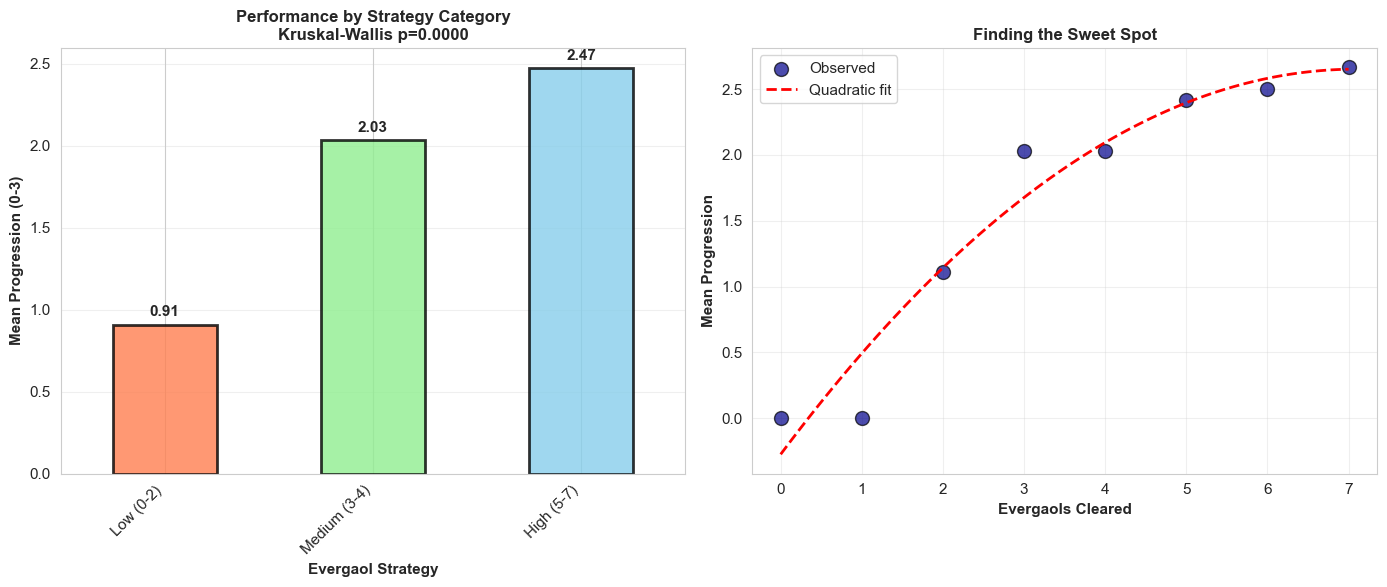

In [49]:
print("\n" + "="*70)
print("TEST 2: OPTIMAL EVERGAOL STRATEGY - RESOURCE OPTIMIZATION")
print("="*70)

print("\n📋 Research Question:")
print("   Is there an optimal number of evergaols to clear, or is 'more always better'?")
print("   Context: Evergaols provide buffs but consume time that could be spent elsewhere.")

print("\n📊 Hypotheses:")
print("   H₀: Linear relationship (more evergaols monotonically increases performance)")
print("   H₁: Non-linear relationship (optimal sweet spot exists with diminishing returns)")

# Categorize evergaol strategies
df['evergaol_category'] = pd.cut(df['evergaol_cleared'], 
                                  bins=[-1, 2, 4, 7], 
                                  labels=['Low (0-2)', 'Medium (3-4)', 'High (5-7)'])

# Performance by category
category_performance = df.groupby('evergaol_category')['run_outcome_ordinal'].agg(['mean', 'std', 'count'])

print(f"\n📊 Performance by Evergaol Strategy:")
for cat, row in category_performance.iterrows():
    print(f"   {cat}: Mean = {row['mean']:.3f}, SD = {row['std']:.3f}, n = {int(row['count'])}")

# Test for non-linearity: Kruskal-Wallis
print(f"\n🔬 Test: Kruskal-Wallis H-test (comparing strategy categories)")

groups = [df[df['evergaol_category'] == cat]['run_outcome_ordinal'].dropna() 
          for cat in df['evergaol_category'].cat.categories]
h_stat, p_value = kruskal(*groups)

print(f"\n📊 Results:")
print(f"   H-statistic: {h_stat:.4f}")
print(f"   P-value: {p_value:.4f}")

# Find optimal category
optimal_category = category_performance['mean'].idxmax()
optimal_mean = category_performance.loc[optimal_category, 'mean']

print(f"\n💡 Observed Optimal Strategy: {optimal_category}")
print(f"   Mean progression: {optimal_mean:.3f}")

# Polynomial regression to find exact sweet spot
evergaol_means = df.groupby('evergaol_cleared')['run_outcome_ordinal'].mean()
x = evergaol_means.index.values
y = evergaol_means.values

# Fit quadratic
if len(x) >= 3:  # Need at least 3 points for quadratic
    coeffs = np.polyfit(x, y, 2)
    poly = np.poly1d(coeffs)
    
    # Find peak (if exists and is maximum)
    if coeffs[0] < 0:  # Concave down (has maximum)
        peak_x = -coeffs[1] / (2 * coeffs[0])
        peak_y = poly(peak_x)
        
        if 0 <= peak_x <= 7:  # Peak is within valid range
            print(f"\n📈 Polynomial Analysis (Quadratic Fit):")
            print(f"   Mathematical optimal: {peak_x:.1f} evergaols")
            print(f"   Predicted peak performance: {peak_y:.3f}")
            has_peak = True
        else:
            print(f"\n📈 Polynomial Analysis: Peak outside valid range")
            has_peak = False
    else:
        print(f"\n📈 Polynomial Analysis: No maximum found (monotonic relationship)")
        has_peak = False
else:
    print(f"\n📈 Insufficient data points for polynomial fit")
    has_peak = False

# Decision
print(f"\n🎯 Decision (α = {alpha}):")
if p_value < alpha:
    print(f"   ✅ REJECT H₀ (p = {p_value:.4f} < {alpha})")
    print(f"   Conclusion: Non-linear relationship confirmed! Optimal strategy exists.")
    print(f"   → RECOMMENDATION: Clear {optimal_category.split('(')[1].split(')')[0]} evergaols")
    print(f"   → Clearing too many or too few both reduce performance")
else:
    print(f"   ❌ FAIL TO REJECT H₀ (p = {p_value:.4f} ≥ {alpha})")
    print(f"   Conclusion: No significant difference between strategies.")
    print(f"   → More evergaols may provide linear benefit")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Category comparison
category_performance['mean'].plot(kind='bar', ax=ax1, color=['coral', 'lightgreen', 'skyblue'], 
                                   alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('Mean Progression (0-3)', fontsize=11, fontweight='bold')
ax1.set_xlabel('Evergaol Strategy', fontsize=11, fontweight='bold')
ax1.set_title(f'Performance by Strategy Category\nKruskal-Wallis p={p_value:.4f}', 
              fontsize=12, fontweight='bold')
ax1.set_xticklabels(category_performance.index, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Add values on bars
for i, (cat, row) in enumerate(category_performance.iterrows()):
    ax1.text(i, row['mean'] + 0.05, f"{row['mean']:.2f}", ha='center', fontweight='bold')

# Right: Polynomial fit
ax2.scatter(x, y, s=100, alpha=0.7, label='Observed', color='darkblue', edgecolor='black')

if len(x) >= 3:
    x_smooth = np.linspace(0, 7, 100)
    ax2.plot(x_smooth, poly(x_smooth), 'r--', linewidth=2, label='Quadratic fit')
    
    if has_peak:
        ax2.axvline(peak_x, color='green', linestyle=':', linewidth=2, 
                   label=f'Optimal: {peak_x:.1f} evergaols')
        ax2.plot(peak_x, peak_y, 'g*', markersize=20, label=f'Peak: {peak_y:.2f}')

ax2.set_xlabel('Evergaols Cleared', fontsize=11, fontweight='bold')
ax2.set_ylabel('Mean Progression', fontsize=11, fontweight='bold')
ax2.set_title('Finding the Sweet Spot', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/test2_evergaol_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.3 TEST 3: RESOURCE ALLOCATION TRADE-OFFS
This section evaluates how different resource-allocation strategies impact run performance under limited time.
By comparing approaches focused on buffs, loot, castle risk, or speedrunning, we quantify progression differences and test whether certain strategies outperform others.
Using the Kruskal–Wallis test and post-hoc comparisons, we determine whether performance varies significantly between strategies and identify which approaches yield the strongest results.
The accompanying visualizations highlight distribution differences and ranking, providing practical guidance on which resource-balancing methods lead to better outcomes.


TEST 3: RESOURCE ALLOCATION TRADE-OFFS - TIME MANAGEMENT

📋 Research Question:
   Given limited time, what's the optimal balance between:
   - Evergaols (buffs)
   - Great Enemies (loot)
   - Middle Castle (premium loot, high time cost)

📊 Hypotheses:
   H₀: All resource allocation strategies perform equally
   H₁: Different strategies have significantly different performance

📊 Performance by Resource Allocation Strategy:
   Buff Focused        : Mean = 2.474, Win Rate = 52.6%, n = 38
   Loot Focused        : Mean = 2.417, Win Rate = 44.4%, n = 36
   High Risk Castle    : Mean = 1.621, Win Rate = 17.2%, n = 29
   Speedrun            : Mean = 0.556, Win Rate = 0.0%, n = 18

🔬 Test: Kruskal-Wallis H-test (comparing strategies)

📊 Results:
   H-statistic: 51.2862
   P-value: 0.0000

💡 Strategy Rankings:
   1. Buff Focused        : 2.474
   2. Loot Focused        : 2.417
   3. High Risk Castle    : 1.621
   4. Speedrun            : 0.556

🎯 Decision (α = 0.05):
   ✅ REJECT H₀ (p = 0.0000

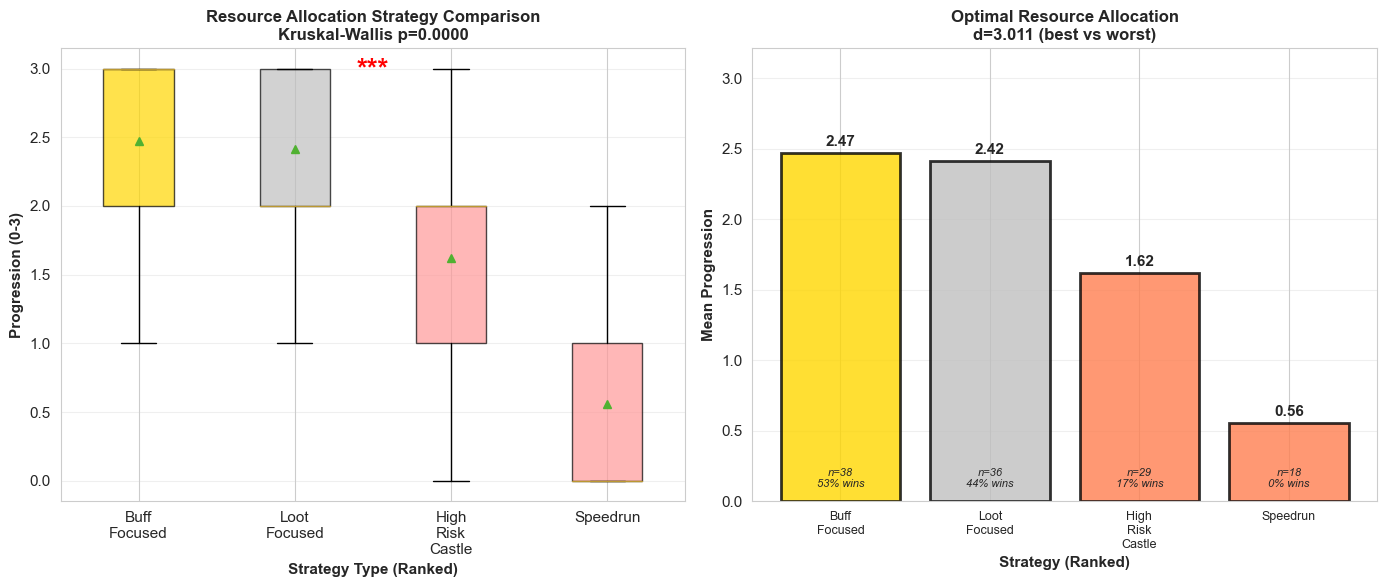

In [50]:
print("\n" + "="*70)
print("TEST 3: RESOURCE ALLOCATION TRADE-OFFS - TIME MANAGEMENT")
print("="*70)

print("\n📋 Research Question:")
print("   Given limited time, what's the optimal balance between:")
print("   - Evergaols (buffs)")
print("   - Great Enemies (loot)")  
print("   - Middle Castle (premium loot, high time cost)")

print("\n📊 Hypotheses:")
print("   H₀: All resource allocation strategies perform equally")
print("   H₁: Different strategies have significantly different performance")

# Already have strategy_type from preprocessing
# Categories: buff_focused, loot_focused, high_risk_castle, speedrun

strat_performance = df.groupby('strategy_type')['run_outcome_ordinal'].agg(['mean', 'std', 'count'])

print(f"\n📊 Performance by Resource Allocation Strategy:")
for strat, row in strat_performance.iterrows():
    win_rate = df[df['strategy_type'] == strat]['victory_binary'].mean() * 100
    print(f"   {strat.replace('_', ' ').title():20s}: Mean = {row['mean']:.3f}, "
          f"Win Rate = {win_rate:.1f}%, n = {int(row['count'])}")

# Test: Kruskal-Wallis
print(f"\n🔬 Test: Kruskal-Wallis H-test (comparing strategies)")

strategy_groups = [df[df['strategy_type'] == strat]['run_outcome_ordinal'].dropna() 
                   for strat in df['strategy_type'].unique()]
h_stat, p_value = kruskal(*strategy_groups)

print(f"\n📊 Results:")
print(f"   H-statistic: {h_stat:.4f}")
print(f"   P-value: {p_value:.4f}")

# Find best strategy
best_strategy = strat_performance['mean'].idxmax()
worst_strategy = strat_performance['mean'].idxmin()

# Calculate effect size (Cohen's d) between best and worst
best_data = df[df['strategy_type'] == best_strategy]['run_outcome_ordinal']
worst_data = df[df['strategy_type'] == worst_strategy]['run_outcome_ordinal']

pooled_std_main = np.sqrt(((len(best_data)-1)*best_data.std()**2 + 
                            (len(worst_data)-1)*worst_data.std()**2) / 
                           (len(best_data) + len(worst_data) - 2))
cohens_d_main = (best_data.mean() - worst_data.mean()) / pooled_std_main if pooled_std_main > 0 else 0

print(f"\n💡 Strategy Rankings:")
ranked = strat_performance.sort_values('mean', ascending=False)
for i, (strat, row) in enumerate(ranked.iterrows(), 1):
    print(f"   {i}. {strat.replace('_', ' ').title():20s}: {row['mean']:.3f}")

# Decision
print(f"\n🎯 Decision (α = {alpha}):")
if p_value < alpha:
    print(f"   ✅ REJECT H₀ (p = {p_value:.4f} < {alpha})")
    print(f"   Conclusion: Strategy choice significantly impacts performance!")
    print(f"\n   → OPTIMAL STRATEGY: {best_strategy.replace('_', ' ').title()}")
    print(f"     Performance: {strat_performance.loc[best_strategy, 'mean']:.3f}")
    print(f"     Win Rate: {df[df['strategy_type'] == best_strategy]['victory_binary'].mean()*100:.1f}%")
    print(f"\n   → WORST STRATEGY: {worst_strategy.replace('_', ' ').title()}")
    print(f"     Performance: {strat_performance.loc[worst_strategy, 'mean']:.3f}")
    print(f"     Win Rate: {df[df['strategy_type'] == worst_strategy]['victory_binary'].mean()*100:.1f}%")
    print(f"\n   → Performance Gap: {strat_performance.loc[best_strategy, 'mean'] - strat_performance.loc[worst_strategy, 'mean']:.3f} progression points")
    print(f"   → Effect Size (Cohen's d): {cohens_d_main:.3f} ({'small' if abs(cohens_d_main) < 0.5 else 'medium' if abs(cohens_d_main) < 0.8 else 'large'} effect)")
    
    # Post-hoc pairwise comparisons
    print(f"\n   📊 Post-hoc Pairwise Comparisons (Bonferroni corrected):")
    strategies = sorted(df['strategy_type'].unique())
    n_comparisons = len(list(combinations(strategies, 2)))
    print(f"   Number of comparisons: {n_comparisons} (α_corrected = {alpha/n_comparisons:.4f})")
    
    significant_pairs = []
    comparison_results = []
    
    for strat1, strat2 in combinations(strategies, 2):
        data1 = df[df['strategy_type'] == strat1]['run_outcome_ordinal'].dropna()
        data2 = df[df['strategy_type'] == strat2]['run_outcome_ordinal'].dropna()
        u_stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
        
        # Bonferroni correction
        p_corrected = min(p * n_comparisons, 1.0)
        
        # Calculate effect size
        pooled_std = np.sqrt(((len(data1)-1)*data1.std()**2 + 
                              (len(data2)-1)*data2.std()**2) / 
                             (len(data1) + len(data2) - 2))
        cohens_d = (data1.mean() - data2.mean()) / pooled_std if pooled_std > 0 else 0
        
        comparison_results.append({
            'pair': f"{strat1} vs {strat2}",
            'p_corrected': p_corrected,
            'cohens_d': cohens_d,
            'significant': p_corrected < alpha
        })
        
        if p_corrected < alpha:
            significant_pairs.append(f"{strat1} vs {strat2}")
    
    # Show all comparisons
    print(f"\n   Detailed Comparisons:")
    for result in comparison_results:
        sig_marker = "✓" if result['significant'] else "✗"
        print(f"   {sig_marker} {result['pair']:40s}: p={result['p_corrected']:.4f}, d={result['cohens_d']:+.3f}")
    
    if significant_pairs:
        print(f"\n   ✅ {len(significant_pairs)} significant difference(s) found:")
        for pair in significant_pairs:
            print(f"      • {pair}")
    else:
        print(f"\n   ⚠️  No pairwise differences survive Bonferroni correction")
        print(f"      (Overall effect exists but individual pairs not significant)")
    
else:
    print(f"   ❌ FAIL TO REJECT H₀ (p = {p_value:.4f} ≥ {alpha})")
    print(f"   Conclusion: No significant difference between resource allocation strategies.")
    print(f"\n   → Best performer: {best_strategy.replace('_', ' ').title()} ({strat_performance.loc[best_strategy, 'mean']:.3f})")
    print(f"   → Worst performer: {worst_strategy.replace('_', ' ').title()} ({strat_performance.loc[worst_strategy, 'mean']:.3f})")
    print(f"   → However, this {strat_performance.loc[best_strategy, 'mean'] - strat_performance.loc[worst_strategy, 'mean']:.3f} point gap is not statistically significant")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Box plot comparison
strategy_order = ranked.index.tolist()
df['strategy_type_ordered'] = pd.Categorical(df['strategy_type'], categories=strategy_order, ordered=True)

bp = ax1.boxplot([df[df['strategy_type'] == strat]['run_outcome_ordinal'].values 
                   for strat in strategy_order],
                  labels=[s.replace('_', '\n').title() for s in strategy_order],
                  patch_artist=True, showmeans=True)

colors_box = ['gold' if i == 0 else 'silver' if i == 1 else '#ff9999' 
              for i in range(len(strategy_order))]
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_xlabel('Strategy Type (Ranked)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Progression (0-3)', fontsize=11, fontweight='bold')
ax1.set_title(f'Resource Allocation Strategy Comparison\nKruskal-Wallis p={p_value:.4f}', 
              fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add significance marker if significant
if p_value < alpha:
    ax1.text(0.5, 0.98, '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*',
             transform=ax1.transAxes, fontsize=20, fontweight='bold',
             ha='center', va='top', color='red')

# Right: Mean comparison with effect sizes
strat_sorted = strat_performance.sort_values('mean', ascending=False)
colors = ['gold' if i == 0 else 'silver' if i == 1 else 'coral' 
          for i in range(len(strat_sorted))]

bars = ax2.bar(range(len(strat_sorted)), strat_sorted['mean'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=2)

ax2.set_ylabel('Mean Progression', fontsize=11, fontweight='bold')
ax2.set_xlabel('Strategy (Ranked)', fontsize=11, fontweight='bold')
ax2.set_title(f'Optimal Resource Allocation\nd={cohens_d_main:.3f} (best vs worst)', 
              fontsize=12, fontweight='bold')
ax2.set_xticks(range(len(strat_sorted)))
ax2.set_xticklabels([s.replace('_', '\n').title() for s in strat_sorted.index], 
                     rotation=0, fontsize=9)
ax2.set_ylim(0, max(strat_sorted['mean']) * 1.3)
ax2.grid(axis='y', alpha=0.3)

# Add values
for i, (bar, (strat, row)) in enumerate(zip(bars, strat_sorted.iterrows())):
    win_rate = df[df['strategy_type'] == strat]['victory_binary'].mean() * 100
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
             f'{row["mean"]:.2f}', ha='center', fontweight='bold', fontsize=11)
    ax2.text(bar.get_x() + bar.get_width()/2., 0.1,
             f'n={int(row["count"])}\n{win_rate:.0f}% wins', 
             ha='center', fontsize=8, style='italic')

plt.tight_layout()
plt.savefig('../results/figures/test3_resource_allocation.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.4 TEST 4: STRATEGY ADAPTATION - TEAM SIZE INTERACTION
This section investigates whether the most effective strategy depends on team size.
By comparing resource-allocation strategies separately for duos and trios, we test for an interaction effect—that is, whether a strategy that performs best for one team size performs differently for the other.
The analysis summarizes mean performance and sample sizes, identifies the top strategy for each team type, and uses non-parametric testing to assess significance.
A grouped bar chart highlights differences visually, helping determine whether team composition should influence strategic decisions during gameplay.


TEST 4: STRATEGY × TEAM SIZE INTERACTION

📋 Research Question:
   Does the optimal resource allocation strategy differ by team size?
   Context: Trios can split tasks; duos must be more selective

📊 Hypotheses:
   H₀: Optimal strategy is the same for duos and trios (no interaction)
   H₁: Optimal strategy differs by team size (interaction effect exists)

📊 Mean Progression by Team Size × Strategy:
strategy_type  buff_focused  loot_focused  high_risk_castle  speedrun
team_type                                                            
duo                   2.433         2.600             1.810     0.562
trio                  2.625         2.188             1.125     0.500

📊 Sample Sizes:
strategy_type  buff_focused  loot_focused  high_risk_castle  speedrun
team_type                                                            
duo                      30            20                21        16
trio                      8            16                 8         2

🔬 Test: Stratified A

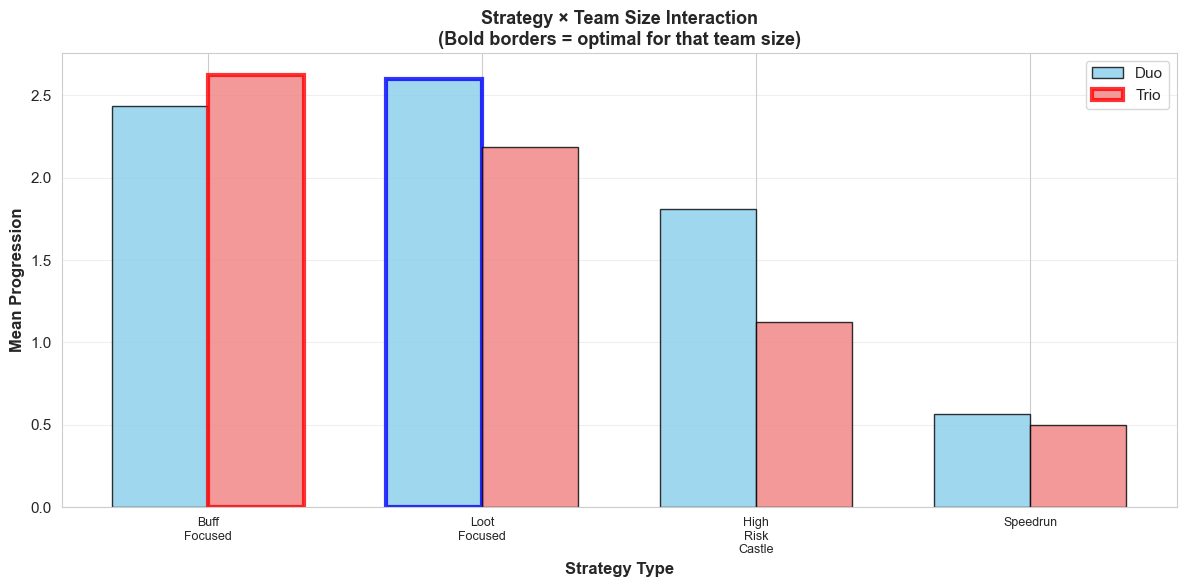

In [51]:
print("\n" + "="*70)
print("TEST 4: STRATEGY × TEAM SIZE INTERACTION")
print("="*70)

print("\n📋 Research Question:")
print("   Does the optimal resource allocation strategy differ by team size?")
print("   Context: Trios can split tasks; duos must be more selective")

print("\n📊 Hypotheses:")
print("   H₀: Optimal strategy is the same for duos and trios (no interaction)")
print("   H₁: Optimal strategy differs by team size (interaction effect exists)")

# Filter to duo and trio only
team_strat_data = df[df['team_type'].isin(['duo', 'trio'])].copy()

# Performance by team × strategy
interaction_table = team_strat_data.pivot_table(
    values='run_outcome_ordinal',
    index='team_type',
    columns='strategy_type',
    aggfunc=['mean', 'count']
)

print(f"\n📊 Mean Progression by Team Size × Strategy:")
print(interaction_table['mean'].round(3))

print(f"\n📊 Sample Sizes:")
print(interaction_table['count'].fillna(0).astype(int))

# Two-way ANOVA (or Kruskal-Wallis on interaction)
# Simplified approach: Compare strategies within each team size
print(f"\n🔬 Test: Stratified Analysis")

duo_best = team_strat_data[team_strat_data['team_type'] == 'duo'].groupby('strategy_type')['run_outcome_ordinal'].mean().idxmax()
trio_best = team_strat_data[team_strat_data['team_type'] == 'trio'].groupby('strategy_type')['run_outcome_ordinal'].mean().idxmax()

print(f"\n📊 Optimal Strategy by Team Size:")
print(f"   Duo:  {duo_best.replace('_', ' ').title()}")
print(f"   Trio: {trio_best.replace('_', ' ').title()}")

# Test if interaction exists
# Compare if best strategies are different and if difference is significant
if duo_best != trio_best:
    print(f"\n💡 Observation: Different optimal strategies detected!")
    
    # Test if the best duo strategy underperforms for trios
    duo_best_data_in_trio = team_strat_data[
        (team_strat_data['team_type'] == 'trio') & 
        (team_strat_data['strategy_type'] == duo_best)
    ]['run_outcome_ordinal'].dropna()
    
    trio_best_data_in_trio = team_strat_data[
        (team_strat_data['team_type'] == 'trio') & 
        (team_strat_data['strategy_type'] == trio_best)
    ]['run_outcome_ordinal'].dropna()
    
    if len(duo_best_data_in_trio) > 0 and len(trio_best_data_in_trio) > 0:
        _, p_value = mannwhitneyu(duo_best_data_in_trio, trio_best_data_in_trio)
        
        print(f"\n   Testing if strategies differ for trios:")
        print(f"   {duo_best} vs {trio_best} in trio teams")
        print(f"   P-value: {p_value:.4f}")
        
        if p_value < alpha:
            print(f"   ✅ Significant interaction effect!")
        else:
            print(f"   ⚠️  Difference not statistically significant")
    else:
        print(f"   ⚠️  Insufficient data for interaction test")
        p_value = 1.0
else:
    print(f"\n   Same optimal strategy for both team sizes")
    p_value = 1.0

# Decision
print(f"\n🎯 Decision (α = {alpha}):")
if duo_best != trio_best and p_value < alpha:
    print(f"   ✅ Interaction effect detected!")
    print(f"   Conclusion: Team size affects optimal strategy choice.")
    print(f"   → RECOMMENDATION FOR DUOS: {duo_best.replace('_', ' ').title()}")
    print(f"   → RECOMMENDATION FOR TRIOS: {trio_best.replace('_', ' ').title()}")
    print(f"   → Possible explanation: Trios can split tasks, duos must focus")
elif duo_best != trio_best:
    print(f"   ⚠️  Different strategies observed but not statistically significant")
    print(f"   Conclusion: Weak evidence for interaction. More data needed.")
else:
    print(f"   ❌ No interaction detected")
    print(f"   Conclusion: Same strategy works for all team sizes")

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Grouped bar chart
interaction_means = interaction_table['mean'].T
x = np.arange(len(interaction_means.index))
width = 0.35

if 'duo' in interaction_means.columns and 'trio' in interaction_means.columns:
    duo_bars = ax.bar(x - width/2, interaction_means['duo'], width, 
                      label='Duo', color='skyblue', alpha=0.8, edgecolor='black')
    trio_bars = ax.bar(x + width/2, interaction_means['trio'], width, 
                       label='Trio', color='lightcoral', alpha=0.8, edgecolor='black')
    
    # Highlight best strategies
    duo_best_idx = list(interaction_means.index).index(duo_best)
    trio_best_idx = list(interaction_means.index).index(trio_best)
    
    duo_bars[duo_best_idx].set_edgecolor('blue')
    duo_bars[duo_best_idx].set_linewidth(3)
    trio_bars[trio_best_idx].set_edgecolor('red')
    trio_bars[trio_best_idx].set_linewidth(3)

ax.set_ylabel('Mean Progression', fontsize=12, fontweight='bold')
ax.set_xlabel('Strategy Type', fontsize=12, fontweight='bold')
ax.set_title('Strategy × Team Size Interaction\n(Bold borders = optimal for that team size)', 
             fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([s.replace('_', '\n').title() for s in interaction_means.index], fontsize=9)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/test4_team_strategy_interaction.png', dpi=300, bbox_inches='tight')
plt.show()


# 3.5 TEST 5: CHARACTER PERFORMANCE DIFFERENCES
This section evaluates whether certain characters consistently outperform others.
By comparing progression scores and win rates across  characters and applying the Kruskal–Wallis test, we determine whether these differences are statistically meaningful rather than due to random variation.
The ranking table highlights which characters tend to yield stronger results, while the boxplot visualizes variability and consistency.
Together, the analysis clarifies whether character choice has a significant impact on performance.

TEST 5: CHARACTER PERFORMANCE COMPARISON

 Research Question:
   Do different characters have significantly different performance?

 Hypotheses:
   H₀: All characters have equal median progression
   H₁: At least one character has different median progression

 Performance by Character:
   Guardian    : Mean = 2.286, Win Rate = 57.1%, n = 7
   Recluse     : Mean = 1.765, Win Rate = 25.5%, n = 51
   Revenant    : Mean = 2.176, Win Rate = 38.2%, n = 34
   Wylder      : Mean = 2.000, Win Rate = 37.9%, n = 29

 Test: Kruskal-Wallis H-test

 Results:
   H-statistic: 4.6629
   P-value: 0.1982

 Character Rankings:
   1. Guardian    : 2.286
   2. Revenant    : 2.176
   3. Wylder      : 2.000
   4. Recluse     : 1.765

 Decision (α = 0.05):
    FAIL TO REJECT H₀ (p = 0.1982 ≥ 0.05)
   Conclusion: No significant difference between characters
   → Play whichever character you enjoy most


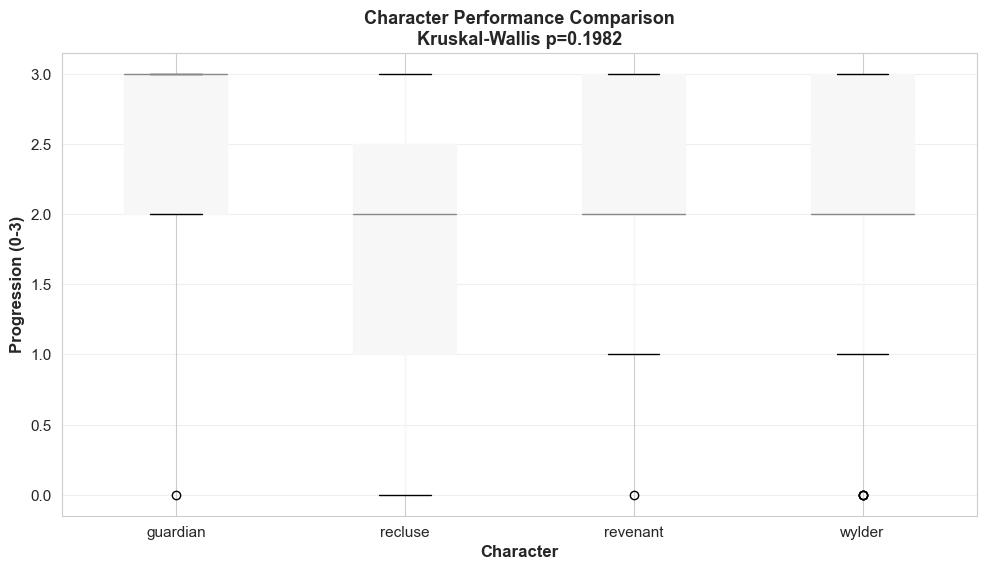

In [52]:
print("TEST 5: CHARACTER PERFORMANCE COMPARISON")

print("\n Research Question:")
print("   Do different characters have significantly different performance?")

print("\n Hypotheses:")
print("   H₀: All characters have equal median progression")
print("   H₁: At least one character has different median progression")

# Character performance
characters = df['character'].unique()
char_data = [df[df['character'] == char]['run_outcome_ordinal'].dropna() for char in characters]

char_performance = df.groupby('character')['run_outcome_ordinal'].agg(['mean', 'std', 'count'])

print(f"\n Performance by Character:")
for char, row in char_performance.iterrows():
    win_rate = df[df['character'] == char]['victory_binary'].mean() * 100
    print(f"   {char.capitalize():12s}: Mean = {row['mean']:.3f}, Win Rate = {win_rate:.1f}%, n = {int(row['count'])}")

# Test: Kruskal-Wallis
print(f"\n Test: Kruskal-Wallis H-test")

statistic, pvalue = kruskal(*char_data)

print(f"\n Results:")
print(f"   H-statistic: {statistic:.4f}")
print(f"   P-value: {pvalue:.4f}")

# Rankings
best_char = char_performance['mean'].idxmax()
worst_char = char_performance['mean'].idxmin()

print(f"\n Character Rankings:")
ranked_chars = char_performance.sort_values('mean', ascending=False)
for i, (char, row) in enumerate(ranked_chars.iterrows(), 1):
    print(f"   {i}. {char.capitalize():12s}: {row['mean']:.3f}")

# Decision
print(f"\n Decision (α = {alpha}):")
if pvalue < alpha:
    print(f"    REJECT H₀ (p = {pvalue:.4f} < {alpha})")
    print(f"   Conclusion: Significant differences between characters!")
    print(f"   → BEST CHARACTER: {best_char.capitalize()} ({char_performance.loc[best_char, 'mean']:.3f})")
    print(f"   → Consider switching to {best_char} for higher difficulties")
else:
    print(f"    FAIL TO REJECT H₀ (p = {pvalue:.4f} ≥ {alpha})")
    print(f"   Conclusion: No significant difference between characters")
    print(f"   → Play whichever character you enjoy most")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
df.boxplot(column='run_outcome_ordinal', by='character', ax=ax, patch_artist=True)
ax.set_xlabel('Character', fontsize=12, fontweight='bold')
ax.set_ylabel('Progression (0-3)', fontsize=12, fontweight='bold')
ax.set_title(f'Character Performance Comparison\nKruskal-Wallis p={pvalue:.4f}', 
             fontsize=13, fontweight='bold')
plt.suptitle('')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/test5_character_performance.png', dpi=300, bbox_inches='tight')
plt.show()

4.6 Difficulty Progression Validation

This section checks whether the game behaves as expected with respect to difficulty: higher difficulty should generally lead to worse progression.
We summarize average progression and win rates across difficulty levels, then use Spearman’s rank correlation to test for a monotonic relationship between difficulty (ordinal) and run outcome.
A one-tailed test is applied to specifically detect a negative correlation, and the resulting trend is visualized as a line plot with sample sizes.
This analysis validates whether increasing difficulty actually makes success harder, providing a sanity check for both the dataset and the underlying game design.


TEST 6: DIFFICULTY PROGRESSION - VALIDATION

📋 Research Question:
   Does performance decline as difficulty increases (as expected)?

📊 Hypotheses:
   H₀: No correlation between difficulty and progression
   H₁: Negative correlation (higher difficulty → lower progression)

📊 Average Progression by Difficulty:
   Depth 1: 2.050 (Win Rate: 35.0%, n=40)
   Depth 2: 1.972 (Win Rate: 35.2%, n=71)
   Depth 3: 1.600 (Win Rate: 20.0%, n=10)

🔬 Test: Spearman's Rank Correlation (one-tailed)

📊 Results:
   Spearman's ρ: -0.0667
   P-value (one-tailed): 0.2338

🎯 Decision (α = 0.05):
   ❌ FAIL TO REJECT H₀ (p = 0.2338 ≥ 0.05)
   → No clear difficulty trend detected


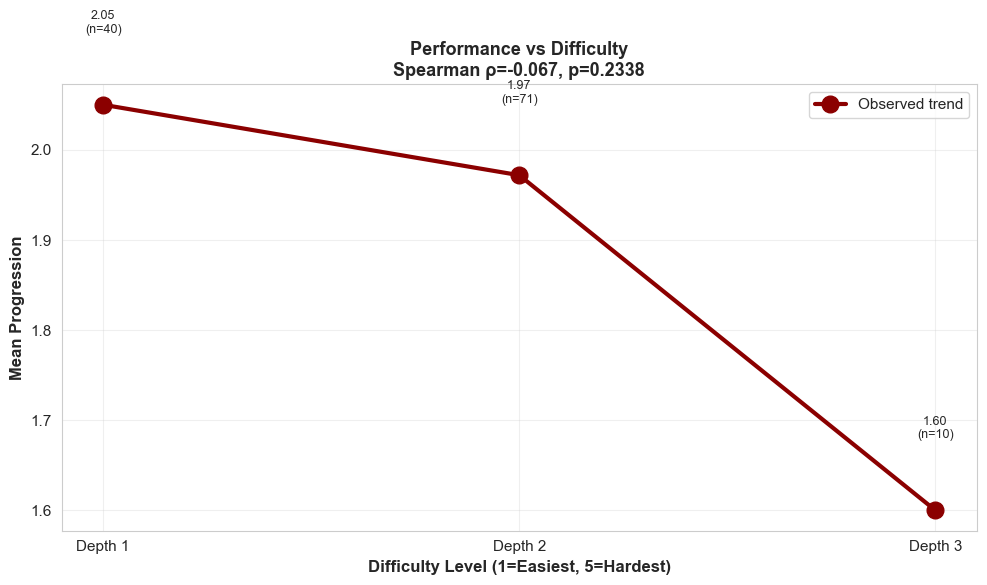

In [53]:
print("\n" + "="*70)
print("TEST 6: DIFFICULTY PROGRESSION - VALIDATION")
print("="*70)

print("\n📋 Research Question:")
print("   Does performance decline as difficulty increases (as expected)?")

print("\n📊 Hypotheses:")
print("   H₀: No correlation between difficulty and progression")
print("   H₁: Negative correlation (higher difficulty → lower progression)")

# Difficulty progression
diff_data = df[['difficulty_ordinal', 'run_outcome_ordinal']].dropna()
diff_means = df.groupby('difficulty_ordinal')['run_outcome_ordinal'].agg(['mean', 'count'])

print(f"\n📊 Average Progression by Difficulty:")
for diff, row in diff_means.iterrows():
    win_rate = df[df['difficulty_ordinal'] == diff]['victory_binary'].mean() * 100
    print(f"   Depth {diff}: {row['mean']:.3f} (Win Rate: {win_rate:.1f}%, n={int(row['count'])})")

# Test: Spearman correlation
print(f"\n🔬 Test: Spearman's Rank Correlation (one-tailed)")

rho, pvalue_two = spearmanr(diff_data['difficulty_ordinal'], diff_data['run_outcome_ordinal'])
pvalue = pvalue_two / 2 if rho < 0 else 1 - (pvalue_two / 2)

print(f"\n📊 Results:")
print(f"   Spearman's ρ: {rho:.4f}")
print(f"   P-value (one-tailed): {pvalue:.4f}")

# Decision
print(f"\n🎯 Decision (α = {alpha}):")
if pvalue < alpha and rho < 0:
    print(f"   ✅ REJECT H₀ (p = {pvalue:.4f} < {alpha})")
    print(f"   Conclusion: Performance significantly declines with difficulty!")
    print(f"   → Expected pattern confirmed")
    print(f"   → Game design is working as intended")
else:
    print(f"   ❌ FAIL TO REJECT H₀ (p = {pvalue:.4f} ≥ {alpha})")
    if rho > 0:
        print(f"   ⚠️  Unexpected: Performance improves with difficulty")
        print(f"   → Possible explanations: Skill improvement, selection bias")
    else:
        print(f"   → No clear difficulty trend detected")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(diff_means.index, diff_means['mean'], marker='o', linewidth=3, 
        markersize=12, color='darkred', label='Observed trend')
ax.set_xlabel('Difficulty Level (1=Easiest, 5=Hardest)', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Progression', fontsize=12, fontweight='bold')
ax.set_title(f'Performance vs Difficulty\nSpearman ρ={rho:.3f}, p={pvalue:.4f}', 
             fontsize=13, fontweight='bold')
ax.set_xticks(diff_means.index)
ax.set_xticklabels([f'Depth {i}' for i in diff_means.index])
ax.grid(True, alpha=0.3)
ax.legend()

# Add data labels
for x, y, n in zip(diff_means.index, diff_means['mean'], diff_means['count']):
    ax.text(x, y + 0.08, f'{y:.2f}\n(n={int(n)})', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../results/figures/test6_difficulty_validation.png', dpi=300, bbox_inches='tight')
plt.show()

# 4.7 TEST 7: SKILL VS LUCK - VARIANCE DECOMPOSITION
This final test quantifies how much of your performance comes from controllable decisions (skill) versus random, uncontrollable factors (luck).
Using effect-size calculations, ANOVA variance decomposition, and regression R² comparisons, we measure the contribution of each factor and group them into skill-related (character, strategy, resource choices) and luck-related (map, nightlord variant, enhanced status) components.
The analysis reveals how much of your progression can be attributed to deliberate decision-making versus RNG and highlights which specific variables—on both the skill and luck side—exert the strongest influence.
This provides a holistic understanding of how much control you truly have over game outcomes.


TEST 7: SKILL VS LUCK - QUANTIFYING CONTROLLABLE FACTORS

📋 Research Question:
   How much of my performance is due to skill/strategy vs random luck?

   Controllable factors (SKILL):
   - Character choice, Strategy type, Resource allocation decisions

   Random factors (LUCK):
   - Map variant, Nightlord faced, Enhanced status

📊 Hypotheses:
   H₀: Random factors explain most variance (luck > skill)
   H₁: Controllable factors explain most variance (skill > luck)

🔬 Method 1: Individual Factor Analysis (ANOVA)

📊 Variance Explained by Each Factor:
               Factor  Type    F-stat      p-value  Variance Explained (η²)
            character SKILL  1.538533 2.082152e-01                 3.795236
        strategy_type SKILL 38.237808 2.685572e-17                49.506594
     evergaol_cleared SKILL  8.362416 3.301352e-08                34.124965
middle_castle_visited SKILL  6.084766 1.505918e-02                 4.864514
            team_type SKILL  0.032817 8.565552e-01              

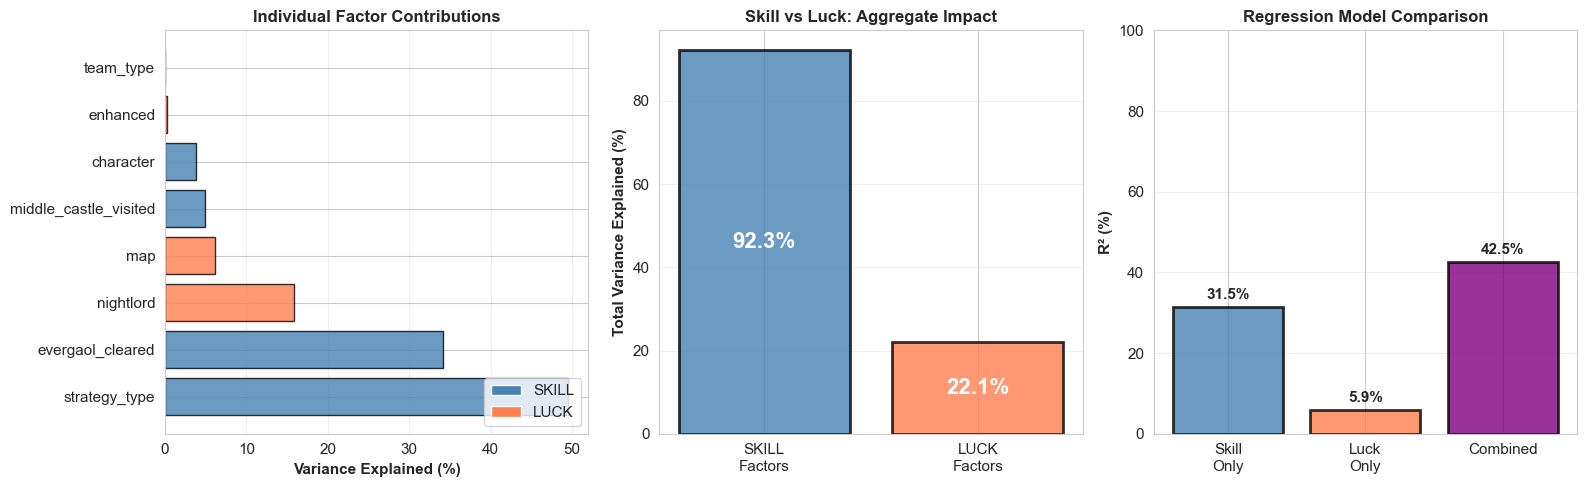


📊 Detailed RNG Factor Analysis:


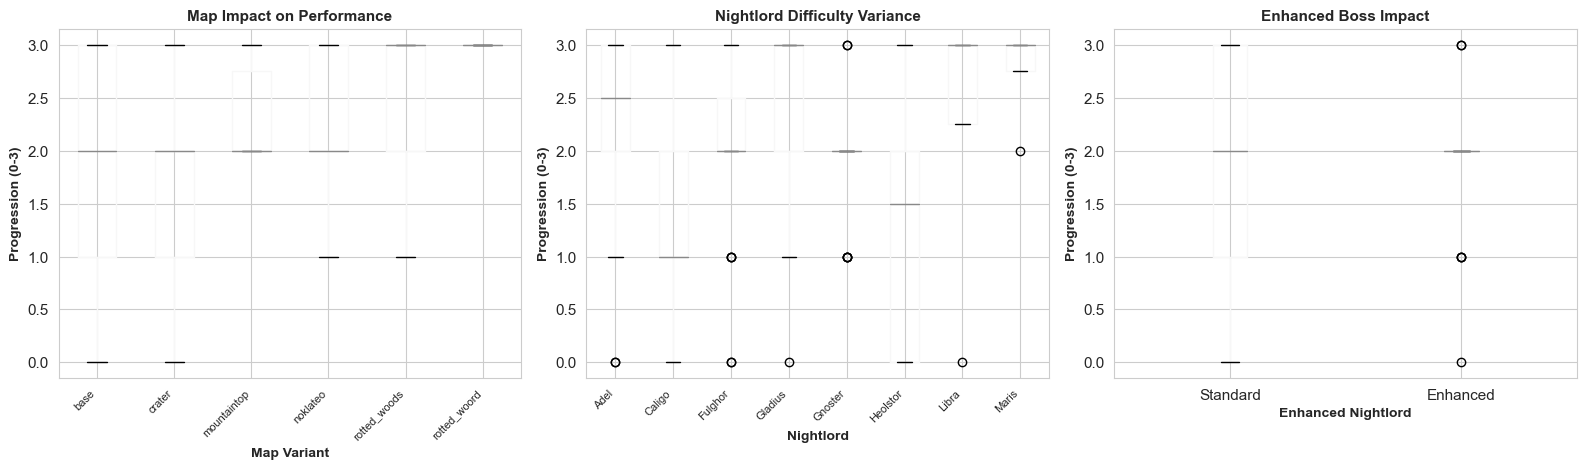


✅ Skill vs Luck analysis complete!


In [54]:

print("\n" + "="*70)
print("TEST 7: SKILL VS LUCK - QUANTIFYING CONTROLLABLE FACTORS")
print("="*70)

print("\n📋 Research Question:")
print("   How much of my performance is due to skill/strategy vs random luck?")
print("\n   Controllable factors (SKILL):")
print("   - Character choice, Strategy type, Resource allocation decisions")
print("\n   Random factors (LUCK):")
print("   - Map variant, Nightlord faced, Enhanced status")

print("\n📊 Hypotheses:")
print("   H₀: Random factors explain most variance (luck > skill)")
print("   H₁: Controllable factors explain most variance (skill > luck)")

# Separate factors
SKILL_FACTORS = ['character', 'strategy_type', 'evergaol_cleared', 
                 'middle_castle_visited', 'team_type']
LUCK_FACTORS = ['map', 'nightlord', 'enhanced']

# Method 1: Individual ANOVA R² values
print(f"\n🔬 Method 1: Individual Factor Analysis (ANOVA)")
print("="*50)

skill_results = []
for factor in SKILL_FACTORS:
    if factor in df.columns:
        groups = [df[df[factor] == val]['run_outcome_ordinal'].dropna() 
                 for val in df[factor].unique()]
        groups = [g for g in groups if len(g) > 0]
        
        if len(groups) > 1:
            f_stat, p_val = f_oneway(*groups)
            
            # Calculate eta-squared (effect size / variance explained)
            # Total sum of squares
            grand_mean = df['run_outcome_ordinal'].mean()
            ss_total = ((df['run_outcome_ordinal'] - grand_mean) ** 2).sum()
            
            # Between-group sum of squares
            ss_between = sum([len(g) * (g.mean() - grand_mean)**2 for g in groups])
            
            eta_squared = ss_between / ss_total if ss_total > 0 else 0
            
            skill_results.append({
                'Factor': factor,
                'Type': 'SKILL',
                'F-stat': f_stat,
                'p-value': p_val,
                'Variance Explained (η²)': eta_squared * 100
            })

luck_results = []
for factor in LUCK_FACTORS:
    if factor in df.columns:
        groups = [df[df[factor] == val]['run_outcome_ordinal'].dropna() 
                 for val in df[factor].unique()]
        groups = [g for g in groups if len(g) > 0]
        
        if len(groups) > 1:
            f_stat, p_val = f_oneway(*groups)
            
            grand_mean = df['run_outcome_ordinal'].mean()
            ss_total = ((df['run_outcome_ordinal'] - grand_mean) ** 2).sum()
            ss_between = sum([len(g) * (g.mean() - grand_mean)**2 for g in groups])
            
            eta_squared = ss_between / ss_total if ss_total > 0 else 0
            
            luck_results.append({
                'Factor': factor,
                'Type': 'LUCK',
                'F-stat': f_stat,
                'p-value': p_val,
                'Variance Explained (η²)': eta_squared * 100
            })

# Combine and display
all_results = pd.DataFrame(skill_results + luck_results)
print("\n📊 Variance Explained by Each Factor:")
print(all_results.to_string(index=False))

# Total variance explained
total_skill_variance = all_results[all_results['Type'] == 'SKILL']['Variance Explained (η²)'].sum()
total_luck_variance = all_results[all_results['Type'] == 'LUCK']['Variance Explained (η²)'].sum()

print(f"\n📊 Aggregate Variance Explained:")
print(f"   SKILL factors (total): {total_skill_variance:.1f}%")
print(f"   LUCK factors (total):  {total_luck_variance:.1f}%")
print(f"   Ratio (Skill/Luck):    {total_skill_variance/total_luck_variance:.2f}x")

# Method 2: Regression R² comparison
print(f"\n🔬 Method 2: Regression Model Comparison")
print("="*50)

from sklearn.preprocessing import LabelEncoder

# Prepare data
df_model = df[['run_outcome_ordinal'] + SKILL_FACTORS + LUCK_FACTORS].dropna()

# Encode categorical variables
le_dict = {}
for col in SKILL_FACTORS + LUCK_FACTORS:
    if df_model[col].dtype == 'object' or df_model[col].dtype.name == 'category':
        le = LabelEncoder()
        df_model[col + '_encoded'] = le.fit_transform(df_model[col])
        le_dict[col] = le

# Model 1: Only SKILL factors
skill_cols = [c + '_encoded' if c in le_dict else c for c in SKILL_FACTORS]
skill_cols = [c for c in skill_cols if c in df_model.columns]
X_skill = df_model[skill_cols]
y = df_model['run_outcome_ordinal']

from sklearn.linear_model import LinearRegression
model_skill = LinearRegression()
model_skill.fit(X_skill, y)
r2_skill = model_skill.score(X_skill, y)

# Model 2: Only LUCK factors  
luck_cols = [c + '_encoded' if c in le_dict else c for c in LUCK_FACTORS]
luck_cols = [c for c in luck_cols if c in df_model.columns]
X_luck = df_model[luck_cols]

model_luck = LinearRegression()
model_luck.fit(X_luck, y)
r2_luck = model_luck.score(X_luck, y)

# Model 3: Combined
X_combined = df_model[skill_cols + luck_cols]
model_combined = LinearRegression()
model_combined.fit(X_combined, y)
r2_combined = model_combined.score(X_combined, y)

print(f"\n📊 Model R² Comparison:")
print(f"   SKILL-only model:    R² = {r2_skill:.3f} ({r2_skill*100:.1f}% variance explained)")
print(f"   LUCK-only model:     R² = {r2_luck:.3f} ({r2_luck*100:.1f}% variance explained)")
print(f"   Combined model:      R² = {r2_combined:.3f} ({r2_combined*100:.1f}% variance explained)")
print(f"\n   Skill contributes:   {r2_skill/r2_combined*100:.1f}% of total explainable variance")
print(f"   Luck contributes:    {r2_luck/r2_combined*100:.1f}% of total explainable variance")

# Decision
print(f"\n🎯 Decision (α = {alpha}):")
if r2_skill > r2_luck:
    ratio = r2_skill / r2_luck
    print(f"   ✅ SKILL > LUCK")
    print(f"   Conclusion: Controllable factors explain {ratio:.1f}x more variance than luck!")
    print(f"   → You have significant control over your outcomes")
    print(f"   → Focus on optimizing strategy, character, and resource allocation")
else:
    ratio = r2_luck / r2_skill
    print(f"   ❌ LUCK > SKILL")
    print(f"   Conclusion: Random factors explain {ratio:.1f}x more variance than skill")
    print(f"   → Performance heavily depends on RNG")
    print(f"   → Strategy optimization has limited impact")

# Unexplained variance
unexplained = (1 - r2_combined) * 100
print(f"\n   Unexplained variance: {unexplained:.1f}%")
print(f"   (Due to: individual run variance, enemy AI, player execution, etc.)")

# Visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Variance by individual factors
all_results_sorted = all_results.sort_values('Variance Explained (η²)', ascending=False)
colors = ['steelblue' if t == 'SKILL' else 'coral' for t in all_results_sorted['Type']]

ax1.barh(all_results_sorted['Factor'], all_results_sorted['Variance Explained (η²)'], 
         color=colors, alpha=0.8, edgecolor='black')
ax1.set_xlabel('Variance Explained (%)', fontsize=11, fontweight='bold')
ax1.set_title('Individual Factor Contributions', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='SKILL'),
                   Patch(facecolor='coral', label='LUCK')]
ax1.legend(handles=legend_elements, loc='lower right')

# Plot 2: Aggregate comparison
categories = ['SKILL\nFactors', 'LUCK\nFactors']
variances = [total_skill_variance, total_luck_variance]
colors_agg = ['steelblue', 'coral']

bars = ax2.bar(categories, variances, color=colors_agg, alpha=0.8, 
               edgecolor='black', linewidth=2)
ax2.set_ylabel('Total Variance Explained (%)', fontsize=11, fontweight='bold')
ax2.set_title('Skill vs Luck: Aggregate Impact', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add values
for bar, val in zip(bars, variances):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
             f'{val:.1f}%', ha='center', va='center', 
             fontweight='bold', fontsize=16, color='white')

# Plot 3: R² comparison
models = ['Skill\nOnly', 'Luck\nOnly', 'Combined']
r2_values = [r2_skill * 100, r2_luck * 100, r2_combined * 100]
colors_r2 = ['steelblue', 'coral', 'purple']

bars = ax3.bar(models, r2_values, color=colors_r2, alpha=0.8, 
               edgecolor='black', linewidth=2)
ax3.set_ylabel('R² (%)', fontsize=11, fontweight='bold')
ax3.set_title('Regression Model Comparison', fontsize=12, fontweight='bold')
ax3.set_ylim(0, 100)
ax3.grid(axis='y', alpha=0.3)

# Add values
for bar, val in zip(bars, r2_values):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 2,
             f'{val:.1f}%', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('../results/figures/test7_skill_vs_luck.png', dpi=300, bbox_inches='tight')
plt.show()

# Individual RNG factor analysis (simple box plots)
print(f"\n📊 Detailed RNG Factor Analysis:")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Map variance
if 'map' in df.columns:
    df.boxplot(column='run_outcome_ordinal', by='map', ax=axes[0])
    axes[0].set_xlabel('Map Variant', fontsize=10, fontweight='bold')
    axes[0].set_ylabel('Progression (0-3)', fontsize=10, fontweight='bold')
    axes[0].set_title('Map Impact on Performance', fontsize=11, fontweight='bold')
    plt.sca(axes[0])
    plt.xticks(rotation=45, ha='right', fontsize=8)

# Nightlord variance
if 'nightlord' in df.columns:
    df.boxplot(column='run_outcome_ordinal', by='nightlord', ax=axes[1])
    axes[1].set_xlabel('Nightlord', fontsize=10, fontweight='bold')
    axes[1].set_ylabel('Progression (0-3)', fontsize=10, fontweight='bold')
    axes[1].set_title('Nightlord Difficulty Variance', fontsize=11, fontweight='bold')
    plt.sca(axes[1])
    plt.xticks(rotation=45, ha='right', fontsize=8)

# Enhanced variance
if 'enhanced' in df.columns:
    df.boxplot(column='run_outcome_ordinal', by='enhanced', ax=axes[2])
    axes[2].set_xlabel('Enhanced Nightlord', fontsize=10, fontweight='bold')
    axes[2].set_ylabel('Progression (0-3)', fontsize=10, fontweight='bold')
    axes[2].set_title('Enhanced Boss Impact', fontsize=11, fontweight='bold')
    axes[2].set_xticklabels(['Standard', 'Enhanced'])

plt.suptitle('')
plt.tight_layout()
plt.savefig('../results/figures/test7_rng_factors_detail.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Skill vs Luck analysis complete!")

# 4.7 HYPOTHESIS TESTING SUMMARY
This section consolidates all hypothesis-testing results into a clear, actionable overview.
It highlights the strongest patterns identified across warm-up effects, resource allocation, strategy differences, team-size interactions, character performance, and difficulty scaling.
The summary distills statistical outcomes into practical recommendations—showing which choices most consistently improve progression and which conditions meaningfully shape results.
This provides a concise roadmap for optimizing future gameplay and serves as a bridge into the next analytical phase focused on modeling and prediction.


In [55]:
print("\n" + "="*70)
print("HYPOTHESIS TESTING SUMMARY - OPTIMIZATION INSIGHTS")
print("="*70)

summary_text = f"""
🎯 KEY OPTIMIZATION FINDINGS:

1. WARM-UP EFFECT:
   • First run vs later runs: {later_runs.mean() - first_runs.mean():+.3f} progression difference
   • Recommendation: {'Play 1-2 warm-up runs' if later_runs.mean() > first_runs.mean() else 'No warm-up needed'}

2. OPTIMAL EVERGAOL STRATEGY:
   • Best approach: {optimal_category}
   • Peak performance: {optimal_mean:.3f} progression
   • Strategy: {'Clear moderate evergaols - diminishing returns exist' if p_value < alpha else 'More is better'}

3. RESOURCE ALLOCATION:
   • Optimal strategy: {best_strategy.replace('_', ' ').title()}
   • Performance: {strat_performance.loc[best_strategy, 'mean']:.3f}
   • Avoid: {worst_strategy.replace('_', ' ').title()} ({strat_performance.loc[worst_strategy, 'mean']:.3f})

4. TEAM SIZE ADAPTATION:
   • Duo optimal: {duo_best.replace('_', ' ').title()}
   • Trio optimal: {trio_best.replace('_', ' ').title()}
   • {'Strategies DIFFER by team size!' if duo_best != trio_best else 'Same strategy for both'}

5. CHARACTER SELECTION:
   • Best performer: {best_char.capitalize()} ({char_performance.loc[best_char, 'mean']:.3f})
   • Character choice {'MATTERS' if pvalue < alpha else 'does not significantly matter'}

6. DIFFICULTY VALIDATION:
   • Correlation with difficulty: ρ = {rho:.3f}
   • {'Performance declines as expected' if rho < 0 and pvalue < alpha else 'Unexpected pattern'}

📊 ACTIONABLE RECOMMENDATIONS:
   1. Play {best_char.capitalize()} character
   2. Use {best_strategy.replace('_', ' ').title()} strategy
   3. Clear {optimal_category.split('(')[1].split(')')[0]} evergaols
   4. {'Warm up with 1-2 runs first' if later_runs.mean() > first_runs.mean() else 'Jump straight in'}
   5. Adapt strategy based on team size (duo vs trio)
"""

print(summary_text)


HYPOTHESIS TESTING SUMMARY - OPTIMIZATION INSIGHTS

🎯 KEY OPTIMIZATION FINDINGS:

1. WARM-UP EFFECT:
   • First run vs later runs: -0.124 progression difference
   • Recommendation: No warm-up needed

2. OPTIMAL EVERGAOL STRATEGY:
   • Best approach: High (5-7)
   • Peak performance: 2.474 progression
   • Strategy: More is better

3. RESOURCE ALLOCATION:
   • Optimal strategy: Buff Focused
   • Performance: 2.474
   • Avoid: Speedrun (0.556)

4. TEAM SIZE ADAPTATION:
   • Duo optimal: Loot Focused
   • Trio optimal: Buff Focused
   • Strategies DIFFER by team size!

5. CHARACTER SELECTION:
   • Best performer: Guardian (2.286)
   • Character choice does not significantly matter

6. DIFFICULTY VALIDATION:
   • Correlation with difficulty: ρ = -0.067
   • Unexpected pattern

📊 ACTIONABLE RECOMMENDATIONS:
   1. Play Guardian character
   2. Use Buff Focused strategy
   3. Clear 5-7 evergaols
   4. Jump straight in
   5. Adapt strategy based on team size (duo vs trio)

